# Experimentation to retrieve the thermical part of the consumption profile

## Content of the notebook

1) The loading of different datasets and the necessary preprocessing;

2) The loading of the model conditionned on the temperature;

3) The way to sample coordinates from the projection;

4) The definition of a temperature of reference;

5) First definition of sensibility :  quantile subtraction;

6) Second definition of sensibility: reference comparison;

7) Third definition of sensibility: gradient local sensibility.

## Loading libraries

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
from FeaturesScore.exploration import *

#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

In [4]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import CVAE.guided_vae_model

import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
importlib.reload(CVAE.guided_vae_model)

%load_ext autoreload
%autoreload

Instructions for updating:
Colocations handled automatically by placer.


## Shapping the data

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset_2012_2017.csv")
x_conso = pd.read_csv(dataset_csv, sep=",").rename(columns={'conso_final':'consumption_France_final'})
x_conso.ds = pd.to_datetime(x_conso.ds)
x_conso_2018 = pd.read_csv(path_data+"/dataset_2018.csv").rename(columns={'consommation_france':'consumption_France_final', 'temperature':'temperature_France', 'prev_J_1':'day_ahead'})
x_conso_2018.ds = pd.to_datetime(x_conso_2018.ds)
x_conso_2018['temperature_France'].interpolate(method='linear',inplace=True)

In [6]:
x_conso_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
ds                          17520 non-null datetime64[ns]
consumption_France_final    17520 non-null float64
is_holiday_day              17520 non-null int64
day_ahead                   17520 non-null float64
temperature_France          17520 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 684.5 KB


In [7]:
x_conso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87830 entries, 0 to 87829
Data columns (total 6 columns):
ds                          87830 non-null datetime64[ns]
consumption_France          87830 non-null float64
temperature_France          87830 non-null float64
is_holiday_day              87830 non-null float64
consumption_France_final    87830 non-null float64
day_ahead                   87830 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.0 MB


In [8]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

In [9]:
dict_xconso = {'train': x_conso[['ds','consumption_France_final', 'temperature_France', 'is_holiday_day', 'day_ahead']], 'test':x_conso_2018[['ds','consumption_France_final', 'temperature_France', 'is_holiday_day', 'day_ahead']]}

In [10]:
# Normalize input variables
dict_xconso, scaler = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France_final']


In [11]:
dict_xconso['train'].describe()

consumption_France_final  temperature_France  is_holiday_day  \
count              8.783000e+04        87830.000000    87830.000000   
mean              -2.588793e-18           12.639393        0.030058   
std                1.000006e+00            6.706958        0.170748   
min               -2.085285e+00           -4.714150        0.000000   
25%               -7.620740e-01            7.452313        0.000000   
50%               -1.347014e-01           12.238112        0.000000   
75%                7.029703e-01           17.484106        0.000000   
max                3.316839e+00           33.451400        1.000000   

          day_ahead  
count  87830.000000  
mean   54170.372971  
std    11903.442325  
min    28500.000000  
25%    45100.000000  
50%    52600.000000  
75%    62400.000000  
max    95100.000000

In [12]:
for key in dict_xconso.keys():
    dict_xconso[key].day_ahead = scaler.transform(dict_xconso[key].day_ahead.values.reshape(-1,1))

In [13]:
for key in dict_xconso.keys():
    dict_xconso[key]["season"] = np.ones_like(dict_xconso[key]['ds'].dt.month.values) *3
    dict_xconso[key]['season'].iloc[np.where((dict_xconso[key]['ds'].dt.month == 10) + (dict_xconso[key]['ds'].dt.month == 4) + ((dict_xconso[key]['ds'].dt.month == 5) * (dict_xconso[key]['ds'].dt.day <= 25)))] = 2
    dict_xconso[key]['season'].iloc[np.where((dict_xconso[key]['ds'].dt.month <= 3) + (dict_xconso[key]['ds'].dt.month >= 11))] = 1                        
                    

In [14]:
dict_xconso['train'].describe()

consumption_France_final  temperature_France  is_holiday_day  \
count              8.783000e+04        87830.000000    87830.000000   
mean              -2.588793e-18           12.639393        0.030058   
std                1.000006e+00            6.706958        0.170748   
min               -2.085285e+00           -4.714150        0.000000   
25%               -7.620740e-01            7.452313        0.000000   
50%               -1.347014e-01           12.238112        0.000000   
75%                7.029703e-01           17.484106        0.000000   
max                3.316839e+00           33.451400        1.000000   

          day_ahead        season  
count  87830.000000  87830.000000  
mean      -0.025392      1.934533  
std        0.992972      0.872195  
min       -2.166786      1.000000  
25%       -0.782032      1.000000  
50%       -0.156390      2.000000  
75%        0.661115      3.000000  
max        3.388913      3.000000

In [15]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)
#list_cond = ['day', 'weekday']
#dataset_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=list_cond)

In [16]:
dataset_temp = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=['temperature', 'season'])
#dataset_temp_month = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=['temperature', 'month','season'])

temperature (1830, 48)
season (1830, 3)
temperature (365, 48)
season (365, 3)


In [17]:
dataset_all_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=['day','weekday', 'month', 'temperature','is_holiday', 'season'])

day (1830, 7)
weekday (1830, 1)
month (1830, 12)
temperature (1830, 48)
is_holiday (1830, 1)
season (1830, 3)
day (365, 7)
weekday (365, 1)
month (365, 12)
temperature (365, 48)
is_holiday (365, 1)
season (365, 3)


In [18]:
#importation des données calendaires
calendar_info={}
for key in dataset.keys():
    calendar_info[key] = pd.DataFrame(dataset[key]['ds'])
    calendar_info[key]['month'] = calendar_info[key].ds.dt.month
    calendar_info[key]['weekday'] = calendar_info[key].ds.dt.weekday
    calendar_info[key]['is_weekday'] = (calendar_info[key].weekday < 5).apply(lambda x:int(x))
    if key == 'train':
        calendar_info[key] = pd.merge(calendar_info[key], x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
    else:
        calendar_info[key] = pd.merge(calendar_info[key], x_conso_2018[['ds', 'is_holiday_day']], on='ds', how ='left')
    
    day_hol = calendar_info[key][['weekday', 'is_holiday_day']].copy().values
    bridge_index=[]
    for i in range(day_hol.shape[0]):
        if day_hol[i,1]==1:
            if day_hol[i,0]==1:
                bridge_index.append(i-1)
            elif day_hol[i,0]==3:
                bridge_index.append(i+1)

    bridges = np.zeros(day_hol.shape[0])
    bridges[np.asarray(bridge_index)] = 1

    calendar_info[key]['potential_bridge_holiday'] = bridges
    
    calendar_info[key].loc[calendar_info[key]['is_holiday_day'].isna(),'is_holiday_day'] = 0
    calendar_info[key]['season'] = np.ones_like(calendar_info[key]['month'].values) *3
    calendar_info[key]['season'].iloc[np.where((calendar_info[key].ds.dt.month == 10) + (calendar_info[key].ds.dt.month == 4) + ((calendar_info[key].ds.dt.month == 5) * (calendar_info[key].ds.dt.day <= 25)))] = 2
    calendar_info[key]['season'].iloc[np.where((calendar_info[key].ds.dt.month <= 3) + (calendar_info[key].ds.dt.month >= 11))] = 1                        
                                    

In [19]:
calendar_info['train'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1830 entries, 0 to 1829
Data columns (total 7 columns):
ds                          1830 non-null datetime64[ns]
month                       1830 non-null int64
weekday                     1830 non-null int64
is_weekday                  1830 non-null int64
is_holiday_day              1830 non-null float64
potential_bridge_holiday    1830 non-null float64
season                      1830 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 114.4 KB


In [20]:
#importation des données météo
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info['train'].ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info['train'].ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [21]:
factorMatrix={}
for key in calendar_info.keys():
    if key =='train' :
        xconso = x_conso
    else:
        xconso=x_conso_2018
    factors = calendar_info[key].iloc[:,1:].copy()
    columns_x = xconso.columns
    conso_idx = np.argmax(['consumption' in c for c in xconso.columns])
    temp_idx = np.argmax(['temperature' in c for c in xconso.columns])
    dates = np.unique(xconso['ds'].dt.date)
    temperatureMean=np.asarray([np.nanmean(xconso[columns_x[temp_idx]].iloc[np.where(xconso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

    factorMatrix[key] = np.c_[factors.values,temperatureMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'is_bridge_day':'category',
    'season':'category',
    'temperature':'regressor',
}

## Tools for evaluation

In [22]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(1, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(1, 3, 2)
    plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(1, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();

In [23]:
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix, center=None):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,-1], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
    if center is not None:
        proj_c = proj2D.transform(center).reshape(1,-1)
        plt.scatter(x=proj_c[:,0],y=proj_c[:,1], c='black', marker='*', s= 500)

In [24]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(list_x,date,scaler,labels=None):
    if labels is None:
        labels=['truth']+['reconstruction_{}'.format(j) for j in np.arange(1,len(list_x))]
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    x = scaler.inverse_transform(list_x[0])
    x_hat = [scaler.inverse_transform(x_hat) for x_hat in list_x[1:]]
    plt.plot(x, label = labels[0])
    for j,x_hat in enumerate(x_hat):
        plt.plot(x_hat, '--', label = labels[j+1])
    plt.title(date)
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

In [25]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

# Modèle classique

In [26]:
batch_size=32
epochs = 800

In [27]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,70,35,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

In [28]:
# paramètres du modèle variationnel choisi

## pour l'erreur de reconstruction (entre L1 et L2)
is_L2_Loss=False

## pour le choix du prior univarié exponentiel entre 'Gaussian' et 'Laplace':
pdf_model = 'Gaussian'

## pour la régularisation de la fonction objectif : VAE classique --> beta = 1 et gamma = 0
Beta = K.variable(0.33, dtype='float32') 

InfoVAE = True #pour activer la régularisation supplémentaire InfoVAE
Gamma = K.variable(66., dtype='float32')

# Chercher avec le conditionnement

## Modèle LEAP-CVAE

Un modèle leap où l'on essaye de conditionner selon la température, et de renforcer l'information des autres facteurs d'importance.

In [31]:
normal_temperature = np.array([5.0,5.7,8.7,11.1,15.0,18.3,20.8,20.6,17.3,13.5,8.5,5.6]).reshape(-1,1)

from sklearn.preprocessing import StandardScaler
temp_scaler = StandardScaler()
normal_temp = temp_scaler.fit_transform(normal_temperature)

temp = {}
for key in ['train', 'test']:
    temp[key]=temp_scaler.transform(np.mean(dataset_all_cond[key]['x'][1][:,20:68],axis=1).reshape(-1, 1))
    
delta_temp={}
for key in ['train', 'test']:
    delta_temp[key] = np.zeros(temp[key].shape)
    for m in np.arange(1,13,step=1):
        id_m = np.where(calendar_info[key]['month']==m)
        delta_temp[key][id_m] = temp[key][id_m] - normal_temp[m-1]
        
dataset_temp_leap= {}
for key in ['train', 'test']:
    dataset_temp_leap[key] = {}
    cond = np.c_[calendar_info[key][['is_holiday_day', 'potential_bridge_holiday']],
                 dataset_all_cond[key]['x'][1][:,0:7],(1-calendar_info[key]['is_weekday'])
                ] #dataset_all_cond[key]['x'][1][:,8:20],(1-calendar_info[key]['is_weekday']),
    dataset_temp_leap[key]['x']=[dataset_temp[key]['x'][0],cond,dataset_temp[key]['x'][1]]
    dataset_temp_leap[key]['y'] = dataset_temp[key]['y']
    dataset_temp_leap[key]['ds'] = dataset_temp[key]['ds']
    
    
"""   
dataset_temp_leap_emb= {}
for key in ['train', 'test']:
    dataset_temp_leap_emb[key] = {}
    cond = np.c_[calendar_info[key][['is_holiday_day', 'potential_bridge_holiday']],
                 dataset_all_cond[key]['x'][1][:,0:7],(1-calendar_info[key]['is_weekday'])
                ] #dataset_all_cond[key]['x'][1][:,8:20],(1-calendar_info[key]['is_weekday']),
    dataset_temp_leap_emb[key]['x']=[dataset_temp_emb[key]['x'][0],cond]+[c_emb for c_emb in dataset_temp_emb[key]['x'][1:]]
    dataset_temp_leap_emb[key]['y'] = dataset_temp_emb[key]['y']
    dataset_temp_leap_emb[key]['ds'] = dataset_temp_emb[key]['ds']
"""

"   \ndataset_temp_leap_emb= {}\nfor key in ['train', 'test']:\n    dataset_temp_leap_emb[key] = {}\n    cond = np.c_[calendar_info[key][['is_holiday_day', 'potential_bridge_holiday']],\n                 dataset_all_cond[key]['x'][1][:,0:7],(1-calendar_info[key]['is_weekday'])\n                ] #dataset_all_cond[key]['x'][1][:,8:20],(1-calendar_info[key]['is_weekday']),\n    dataset_temp_leap_emb[key]['x']=[dataset_temp_emb[key]['x'][0],cond]+[c_emb for c_emb in dataset_temp_emb[key]['x'][1:]]\n    dataset_temp_leap_emb[key]['y'] = dataset_temp_emb[key]['y']\n    dataset_temp_leap_emb[key]['ds'] = dataset_temp_emb[key]['ds']\n"

In [32]:
dataset_temp_leap['train']['x']

for key in ['train', 'test']:
    temp=dataset_temp_leap[key]['x'][2][:,:48]
    dataset_temp_leap[key]['x'][2] = np.c_[np.mean(temp,axis=1).reshape(-1,1),
                                           np.min(temp,axis=1).reshape(-1,1),
                                           np.max(temp,axis=1).reshape(-1,1),
                                           dataset_temp_leap[key]['x'][2][:,48:]]
    
dataset_temp_leap['train']['x'][2].shape

(1830, 6)

In [35]:
test = 1
#name_model = 'cvae_temp_month'
name_model = 'cvae_temp_emb'
log_dir_projector=path_main_folder+"/notebooks/logs/Thermo/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Thermo/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
e_leap_dims = [4*z_dim]

Beta = K.variable(1, dtype='float32') 
z_dim=3

running = False
if running == True:
    for k in range(10000):
        try:

            model_CVAE_cond_leap = CVAE.guided_vae_model.LEAP_CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dims=6, e_leap_dims=e_leap_dims,
                                InfoVAE=True, beta=Beta, gamma=Gamma, is_L2_Loss=False,
                                tau_dims = dataset_temp_leap['train']['x'][1].shape[1],
                                #to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)
            tensorboard = TensorBoard(log_dir="logs/Thermo/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)

            model_CVAE_cond_leap.main_train(dataset_temp_leap, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)
            
            #emb_inputs=dataset_temp_leap_emb['train']['x'][2:]
            #emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)
            input_encoder = dataset_temp_leap['train']['x']
            x_train_encoded = model_CVAE_cond_leap.encoder.predict(input_encoder)[0]
            
            model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded, factorMatrix['train'], factorDesc, orthogonalize=True)
            test = model_eval['informativeness'][-1] #* model_eval['informativeness'][-2] * model_eval['informativeness'][0]
            print('run {} : {}'.format(k,model_eval['informativeness'][-1]))
            if test <0.1: break

        except ValueError:
            pass
        
if (1 - running):
    model_CVAE_cond_leap = CVAE.guided_vae_model.LEAP_CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dims=6, e_leap_dims=e_leap_dims,
                                InfoVAE=True, beta=Beta, gamma=Gamma, is_L2_Loss=False,
                                tau_dims = dataset_temp_leap['train']['x'][1].shape[1],
                                #to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)
    model_CVAE_cond_leap.load_model(os.path.join(path_out, name_model, 'models'))

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
tau_true (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
cond_true (InputLayer)          (None, 6)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 3), (None, 3 6362        x_true[0][0]                     
                                                              

Mutual Information Gap : 0.05


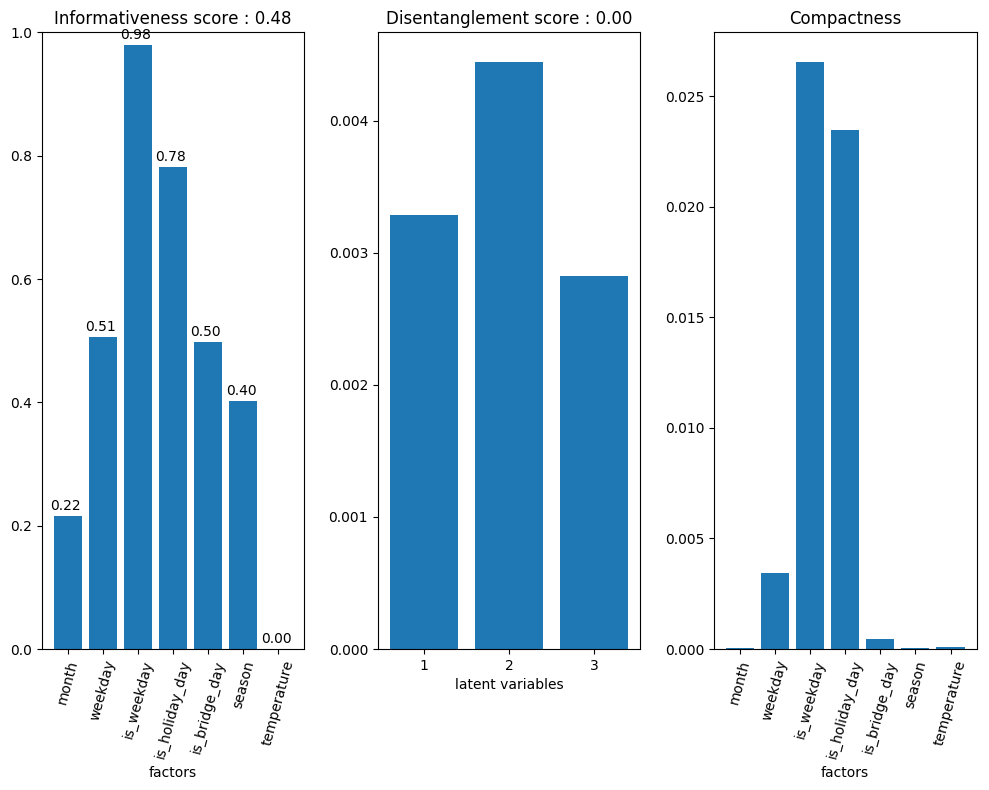

In [36]:

input_encoder = dataset_temp_leap['train']['x']
x_train_encoded = model_CVAE_cond_leap.encoder.predict(input_encoder)[0]


input_encoder = dataset_temp_leap['test']['x']
x_test_encoded = model_CVAE_cond_leap.encoder.predict(input_encoder)[0]
    
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

On vérifie ici que la température n'intervient plus dans la représentation latente.

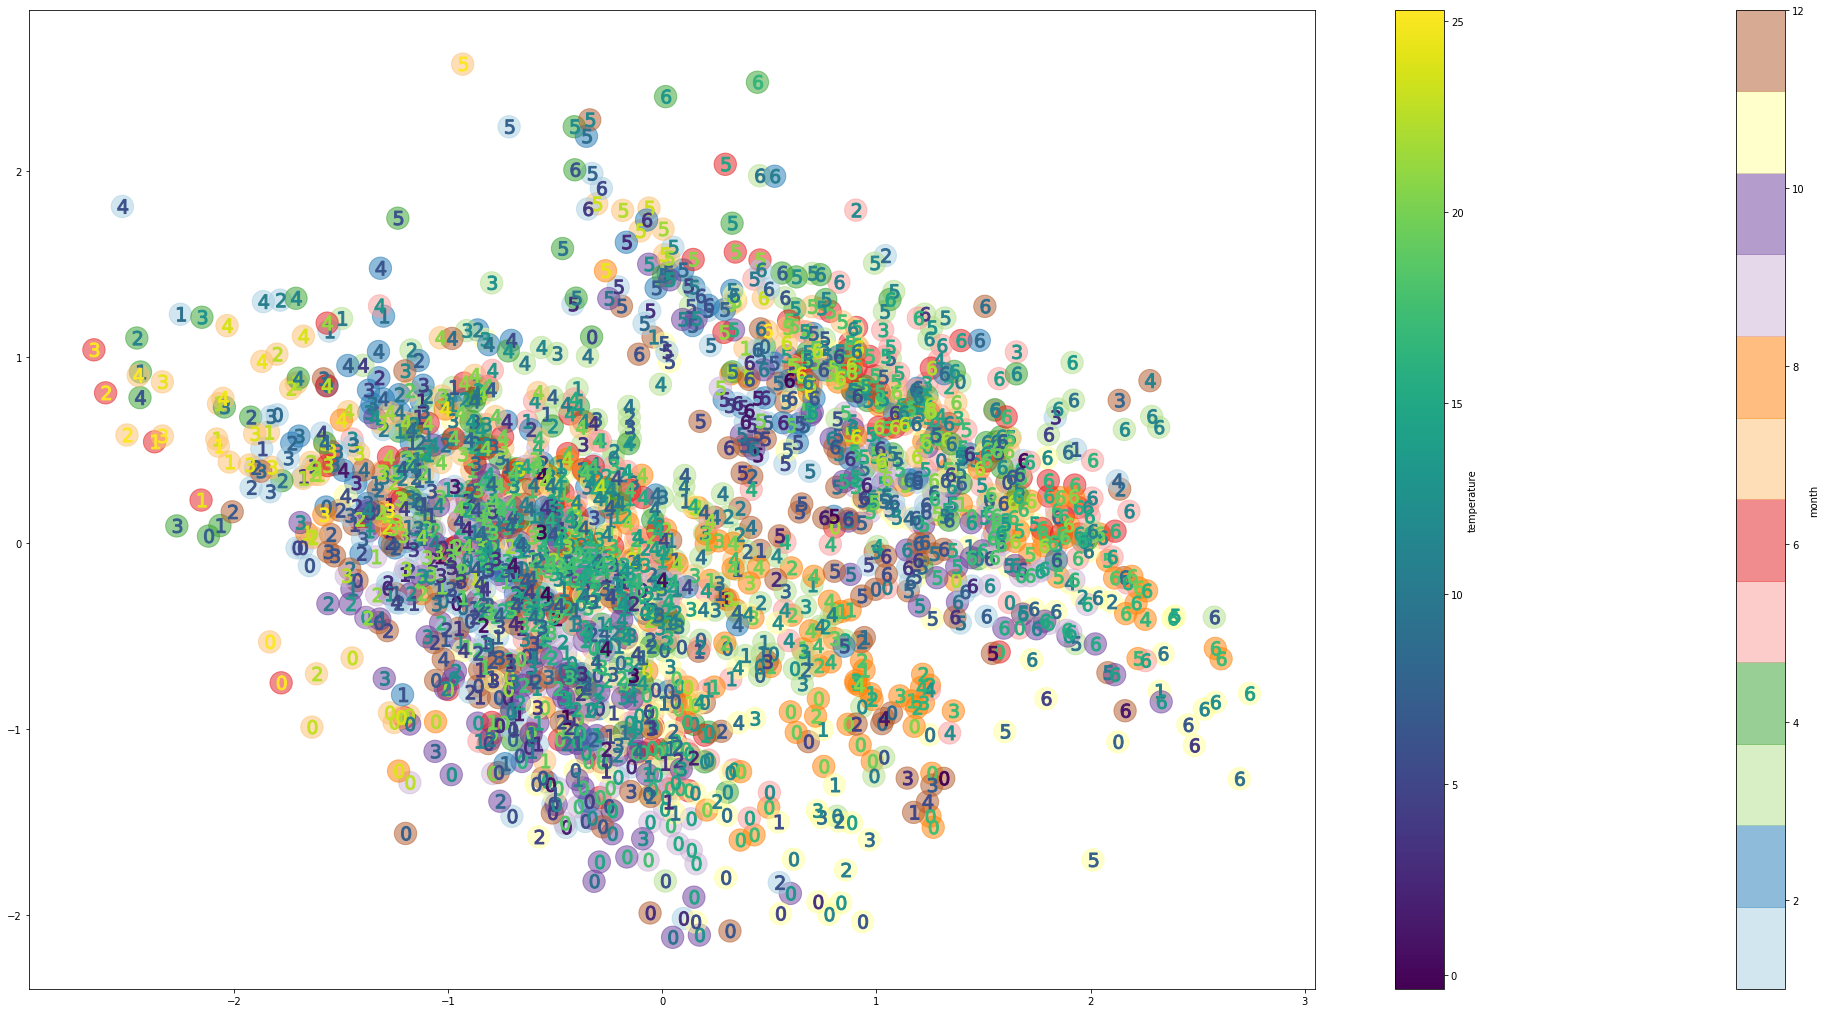

In [37]:
prez_2D(x_train_encoded, factorMatrix['train'])

In [165]:
x_hat = model_CVAE_cond_leap.cvae.predict(input_encoder)[0]
mae_error = np.sum(np.abs((dataset_temp_emb['test']['x'][0] - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((dataset_temp_emb['test']['x'][0] - x_hat)**2, axis=1)) 
#faire un histogramme des écarts
sn.distplot(mae_error, kde=False, fit=stats.norm, bins=100)
print(np.mean(mae_error))

3.5838632218725563


## Modélisation de la projection latente pour faire du sampling


In [485]:
GM_new = GaussianMixture(n_components=3,weights_init=np.array([0.03,0.29,0.68]), n_init=100, random_state=42)
GM_new.fit(x_train_encoded)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=100, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False,
        weights_init=array([0.03, 0.29, 0.68]))

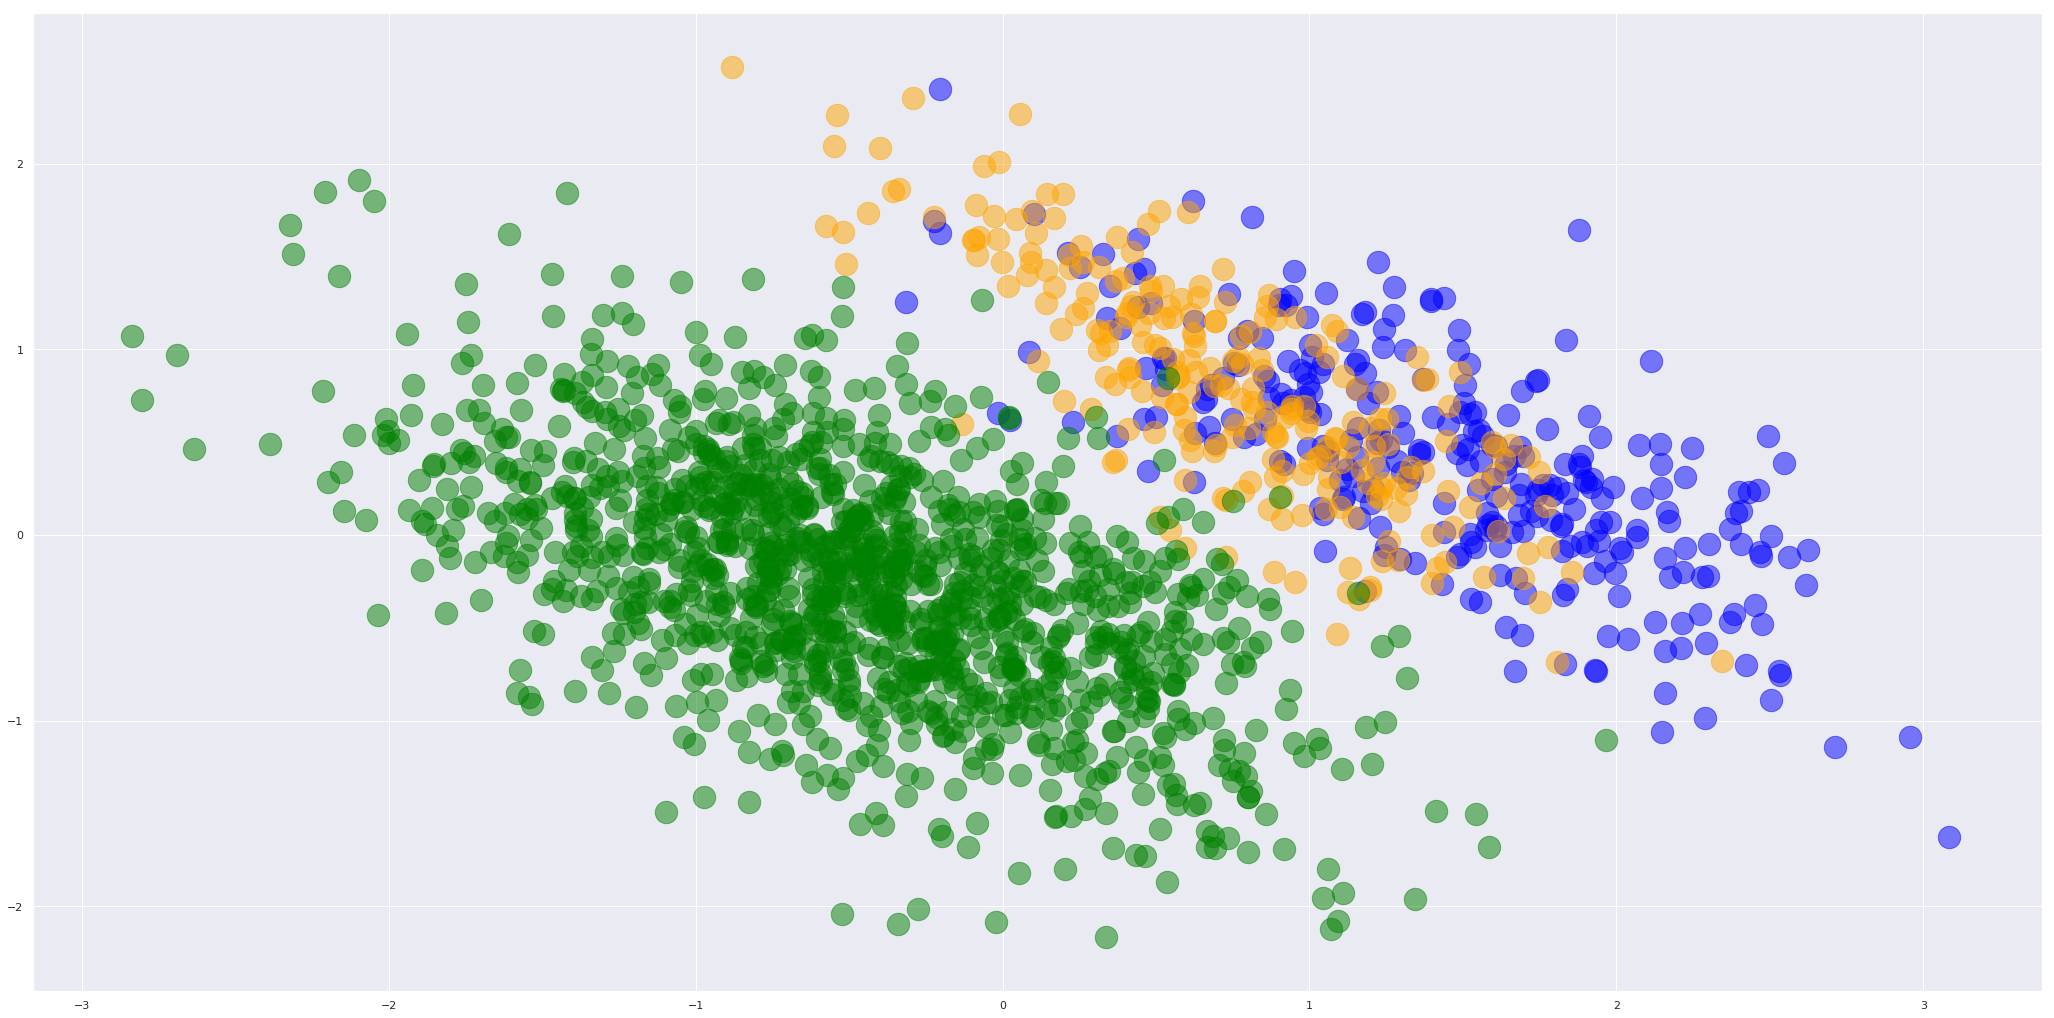

In [486]:
colors = ['blue', 'orange', 'green']
test_GM = GM_new.sample(n_samples=nPoints)
proj2D = PCA(2)
proj = proj2D.fit_transform(test_GM[0])
plt.figure(figsize=(36,18))
    
#visualisation des mois par un disque de fond coloré
for i in np.unique(test_GM[1]):
    i = int(i)
    index = test_GM[1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= colors[i], marker = 'o', s=500, alpha=0.5)

In [166]:
from sklearn.mixture import GaussianMixture
GM = GaussianMixture(n_components=2, n_init=100, random_state=42)
GM.fit(x_train_encoded)
#GM.get_params(deep=True)

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 2,
 'n_init': 100,
 'precisions_init': None,
 'random_state': 42,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [167]:
prez_2D(GM.sample(n_samples=nPoints)[0], factorMatrix['train'])

## Identification de la température de référence

Pour toutes les températures réalisées, on regarde un échantillonage de 500à éléments pour lesquels on va prendre un quantile à 99% à chaque pas horaire. La température de référence sera celle qui minimile l'énergie de la journée prise comme la somme des quantiles à 99%. 

$T_{ref},S_{ref} = \text{argmin}_{T,S} \sum_{t=1}^{48} q_{99\%} (p_\theta(X_t|T,S))$

In [170]:
list_mean = []
list_up = []
temp_median = dataset_temp_leap['train']['x'][2][:,1]
for idd in range(nPoints):
    cond_ind = dataset_temp_leap['train']['x'][2][idd,:]
#    mean_temp = np.mean(cond_ind[:48])
    k=5000
    z_coord = GM.sample(n_samples=k)[0]
    cond = np.tile(cond_ind.reshape(1,-1), (k,1))

    x_hat_pred = model_CVAE_cond_leap.decoder.predict([z_coord, cond])
    mean_pred = np.mean(x_hat_pred, axis=0)
    max_pred = np.quantile(x_hat_pred,0.99, axis=0)
    list_mean.append(mean_pred)
    list_up.append(max_pred)

In [172]:
np.asarray(list_up).shape

(1830, 48)

Je cherche une référence parmi les jours non atypiques, donc j'exclus les jours de weekend, les jours fériés.

In [171]:
#stress = np.abs(np.sum(dataset_leap['train']['x'][1],axis=1))
crit = [np.where((calendar_info['train'].is_holiday_day.values ==0)*(calendar_info['train'].is_weekday.values !=0) *(calendar_info['train'].season.values ==s))[0] for s in [1,2,3]]
ind_ref = [np.argsort(np.sum(np.asarray(list_up)[cr,:],axis=1),axis=0)[0] for cr in crit]
ind_ref

[276, 259, 376]

In [173]:
target = [calendar_info['train'].iloc[crit[i]].iloc[ind_ref[i]] for i in range(3)]
target

[ds                          2015-11-06 00:00:00
 month                                        11
 weekday                                       4
 is_weekday                                    1
 is_holiday_day                                0
 potential_bridge_holiday                      0
 season                                        1
 Name: 1043, dtype: object, ds                          2017-05-16 00:00:00
 month                                         5
 weekday                                       1
 is_weekday                                    1
 is_holiday_day                                0
 potential_bridge_holiday                      0
 season                                        2
 Name: 1600, dtype: object, ds                          2017-06-21 00:00:00
 month                                         6
 weekday                                       2
 is_weekday                                    1
 is_holiday_day                                0
 potential_brid

In [211]:
ind_ref=[1043,1600,1636]

In [376]:
temp_ref = [temp_median[ind] for ind in ind_ref]
conso_ref = [scaler.inverse_transform(np.asarray(list_mean)[ind,:]) for ind in ind_ref]

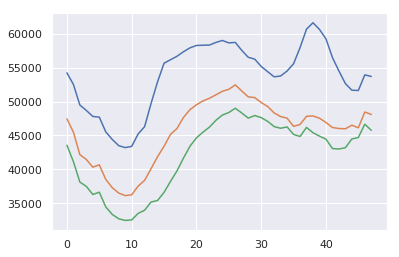

In [377]:
for i in range(3):
    plt.plot(conso_ref[i])

In [423]:
temp_ref

[13.0268, 14.01475, 20.14625]

# Sensibilité définie selon un quantile bas

Part thermo-sensible $X_{T_0,S_0} = q_{0.3\%}\ p_\theta(X|T_0,S_0)$

Part influencée par les autres facteurs :  $X_{F\backslash\{T_0,S_0\}} = D\circ E (X) - X_{T_0,S_0}$

In [177]:
import seaborn as sns

sns.set()

2013-06-04 00:00:00 3


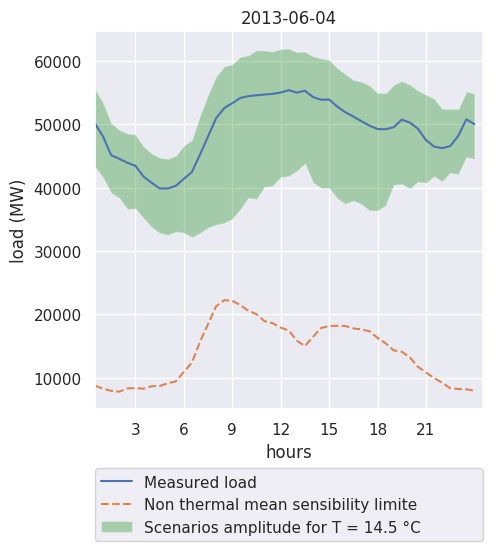

In [489]:
indice=158
q_alpha=0.01

#on récupère les informations nécessaires au décodage
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling sur l'espace latent et reconstruction
k=5000
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


#désagrégation
x = dataset_temp_leap['train']['x'][0][indice,:]

thermal_part = np.quantile(x_hat_pred,0.003,axis=0)
non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part

#Plot des courbes et de l'amplitude des scénarios
scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'Non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Scenarios amplitude for T = %0.1f °C'%cond_ind[0]);
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);


2013-08-03 00:00:00 3


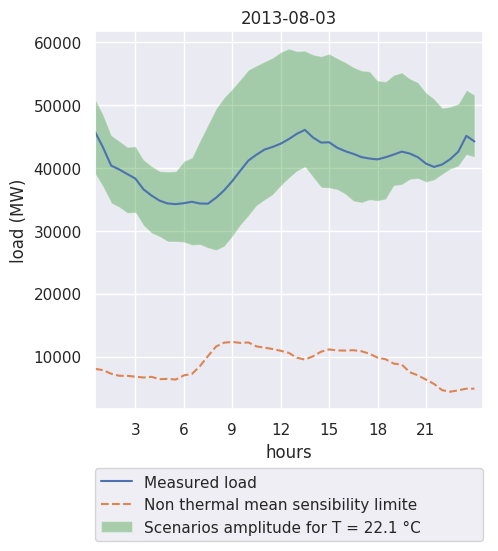

In [490]:
indice=218
q_alpha=0.01

#on récupère les informations nécessaires au décodage
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling sur l'espace latent et reconstruction
k=5000
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


#désagrégation
x = dataset_temp_leap['train']['x'][0][indice,:]

thermal_part = np.quantile(x_hat_pred,0.003,axis=0)
non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part

#Plot des courbes et de l'amplitude des scénarios
scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'Non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Scenarios amplitude for T = %0.1f °C'%cond_ind[0]);
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);


In [137]:
plt.plot(temp_ref_s)

In [491]:
indice=256
q_alpha=0.01

#on récupère les informations nécessaires au décodage
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling sur l'espace latent et reconstruction
k=5000
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


#désagrégation
x = dataset_temp_leap['train']['x'][0][indice,:]

thermal_part = np.quantile(x_hat_pred,0.003,axis=0)
non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part

#Plot des courbes et de l'amplitude des scénarios
scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'Non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Scenarios amplitude for T = %0.1f °C'%cond_ind[0]);
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);


2013-09-10 00:00:00 3


2013-12-30 00:00:00 1


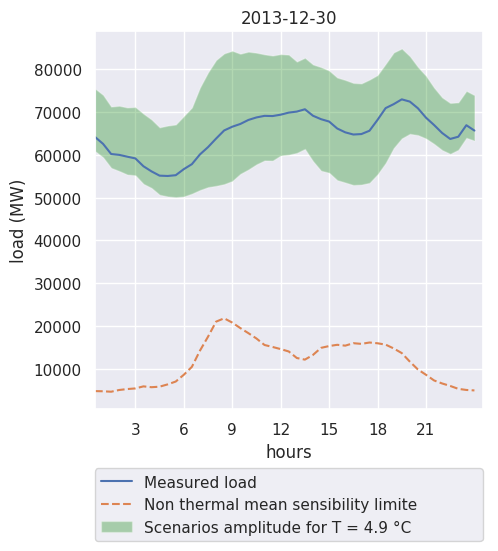

In [492]:
indice=367
q_alpha=0.01

#on récupère les informations nécessaires au décodage
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling sur l'espace latent et reconstruction
k=5000
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


#désagrégation
x = dataset_temp_leap['train']['x'][0][indice,:]

thermal_part = np.quantile(x_hat_pred,0.003,axis=0)
non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part

#Plot des courbes et de l'amplitude des scénarios
scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'Non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Scenarios amplitude for T = %0.1f °C'%cond_ind[0]);
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);


2013-07-22 00:00:00 3


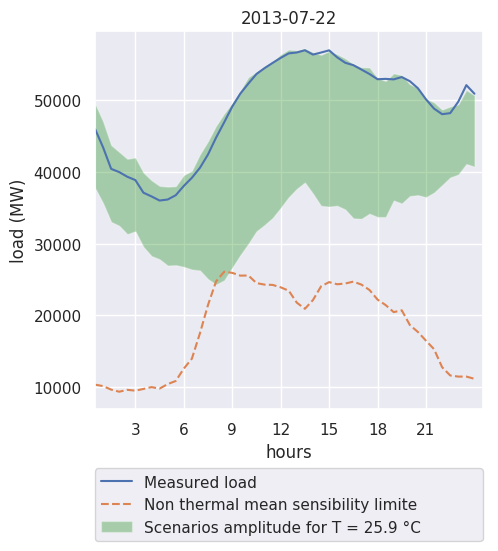

In [493]:
indice=206
q_alpha=0.01

#on récupère les informations nécessaires au décodage
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling sur l'espace latent et reconstruction
k=5000
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


#désagrégation
x = dataset_temp_leap['train']['x'][0][indice,:]

thermal_part = np.quantile(x_hat_pred,0.003,axis=0)
non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part

#Plot des courbes et de l'amplitude des scénarios
scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'Non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Scenarios amplitude for T = %0.1f °C'%cond_ind[0]);
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);


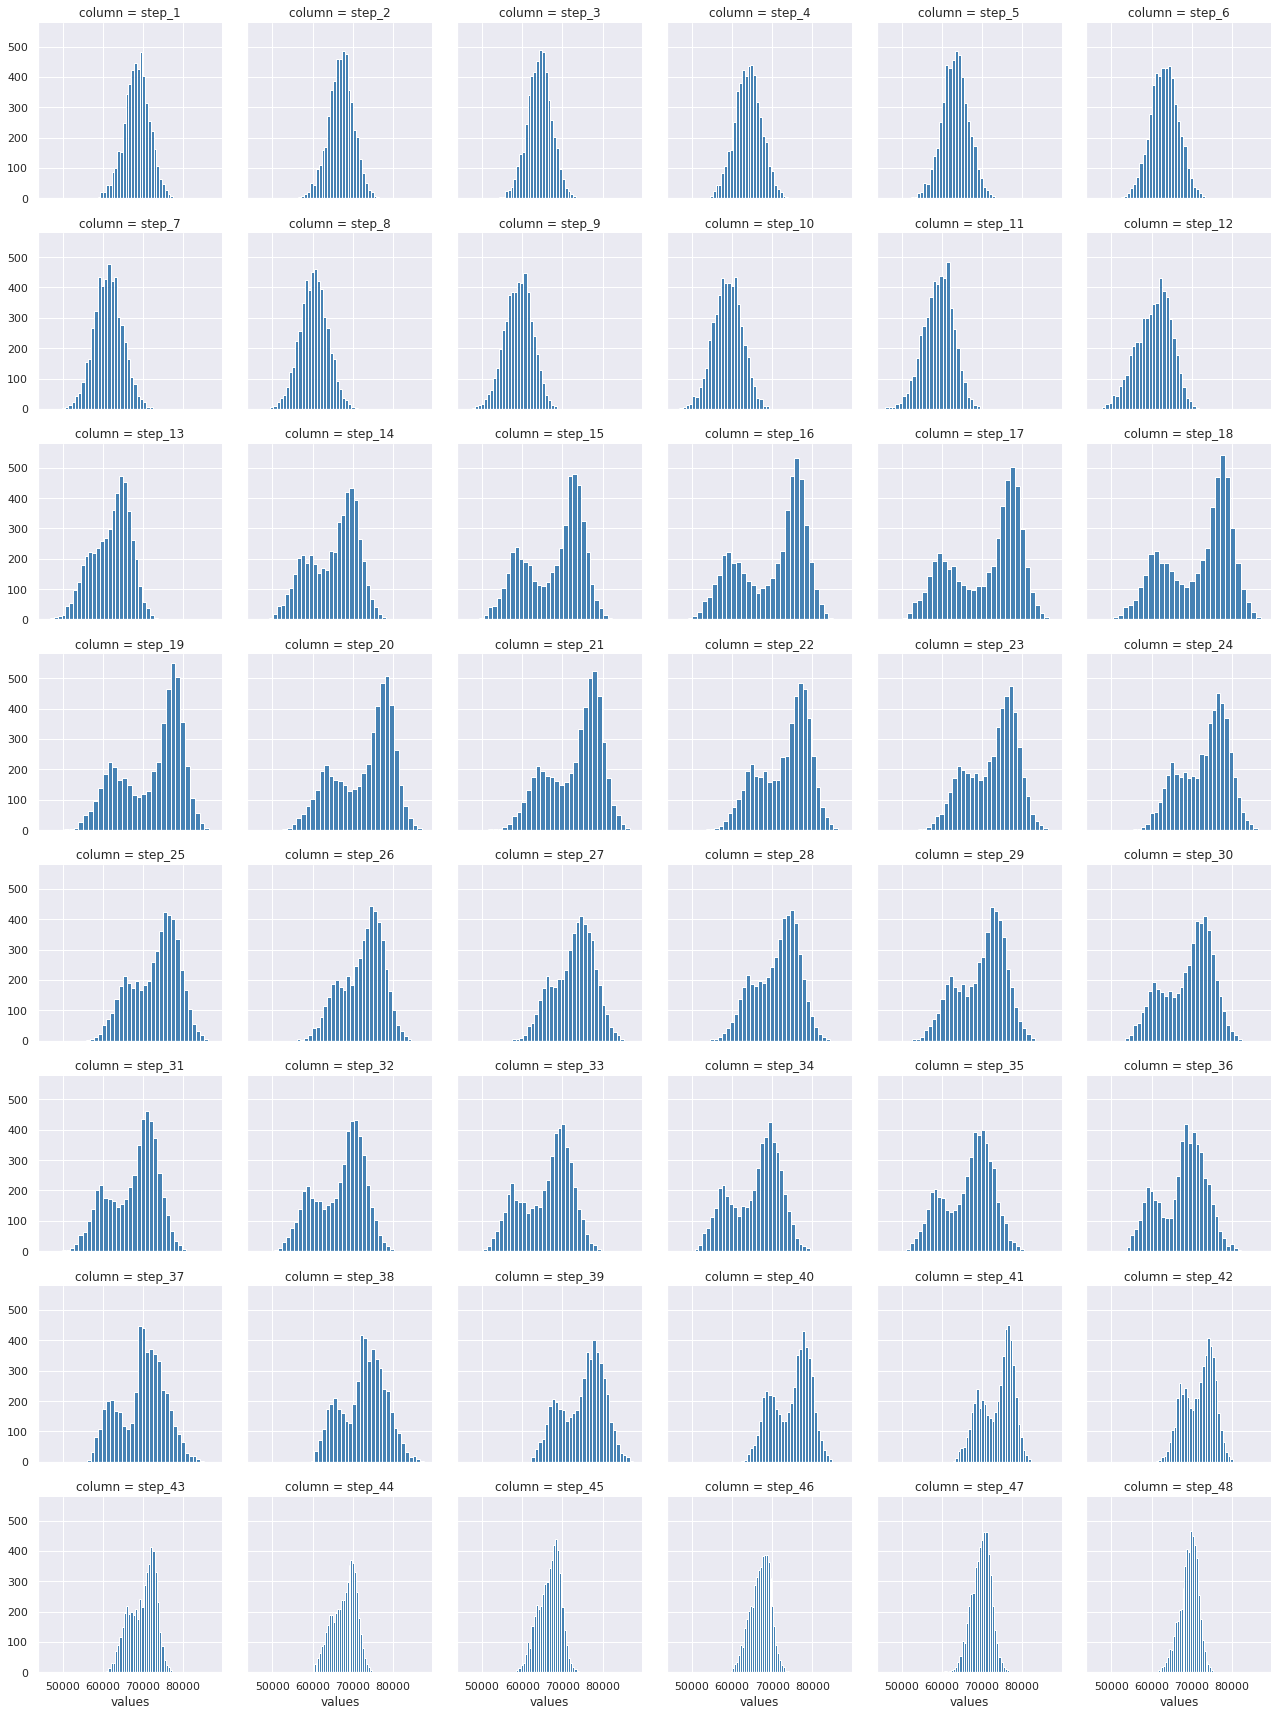

In [182]:
#pour observer les histogrammes des pas de temps horaires
df=pd.DataFrame(data=x_hat_pred, columns=['step_{}'.format(i+1) for i in range(48)])

df_stacked = df.stack().reset_index(1).rename({'level_1': 'column', 0: 'values'},axis=1)
g = sns.FacetGrid(df_stacked, col='column', col_wrap=6)
g.map(plt.hist, 'values',color="steelblue",bins=30);


In [585]:
#calculer le gradient de température, on effectue le même processus sur 1000 indices pris au hasard
num=1000
grad_list=[]
fix_list=[]
idx = np.random.choice(range(nPoints), size=num, replace=False)

for idd in idx:
    k=5000
    cond_ind = dataset_temp_leap['train']['x'][2][idd,:]
    tau_ind = dataset_temp_leap['train']['x'][1][idd,:]
    mean_temp = cond_ind[0]
    
    
    z_coord = GM.sample(n_samples=k)[0]
    
    cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


    x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


    x = dataset_temp_leap['train']['x'][0][idd,:]
   
    thermal_part = np.quantile(x_hat_pred,0.003,axis=0)

    scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
    scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

    non_thermal = scaler.inverse_transform(x) - thermal_part


    grad_list.append(np.c_[mean_temp.reshape(1,-1), thermal_part.reshape(1,-1)])
    fix_list.append(np.c_[mean_temp.reshape(1,-1), (non_thermal).reshape(1,-1)])
    

In [586]:
#On transforme les listes en array-like, la première colonne étant la valeur de la température moyenne
thermo_part = np.asarray(grad_list).reshape(num,49)
fixed_part = np.asarray(fix_list).reshape(num,49)

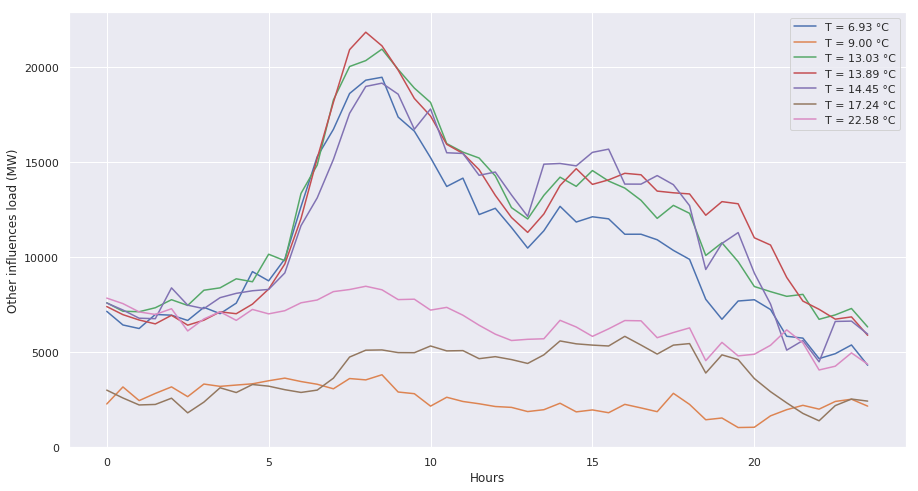

In [587]:
#On observe une prise aléatoire de courbes influencées par les autres facteurs

choices = np.random.choice(range(1000),7)

plt.figure(figsize=(15,8))
for ind in choices[np.argsort(fixed_part[choices,0])]:
    
    plt.plot(np.arange(48,step=1)/2,fixed_part[ind,1:], label='T = %0.2f °C'%fixed_part[ind,0])
plt.ylabel('Other influences load (MW)')
plt.xlabel('Hours')
plt.legend(loc='best')

In [588]:
#On observe une prise aléatoire de courbes influencées par la températureb


plt.figure(figsize=(15,8))
for ind in choices[np.argsort(thermo_part[choices,0])]:
    
    plt.plot(np.arange(48,step=1)/2,thermo_part[ind,1:], label='T = %0.2f °C'%thermo_part[ind,0])
plt.ylabel('Thermo-sensitive load (MW)')
plt.xlabel('Hours')
plt.legend(loc='best')

### Pour observer en 3D les courbes

In [589]:
from mpl_toolkits import mplot3d
X = np.tile(thermo_part[:,0].reshape(-1,1),(1,48))
Y = np.tile(np.arange(0,24,step=0.5).reshape(1,-1), (X.shape[0],1))
Z = thermo_part[:,1:]
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('temperature')
ax.set_ylabel('time')
ax.set_title('Thermal explained load (%)');

ax.view_init(25, 60)
    



In [590]:
from mpl_toolkits import mplot3d
X = np.tile(thermo_part[:,0].reshape(-1,1),(1,48))
Y = np.tile(np.arange(0,24,step=0.5).reshape(1,-1), (X.shape[0],1))
Z = thermo_part[:,1:]
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('temperature')
ax.set_ylabel('time')
ax.set_title('Thermal explained load (%)');

ax.view_init(15, 0)

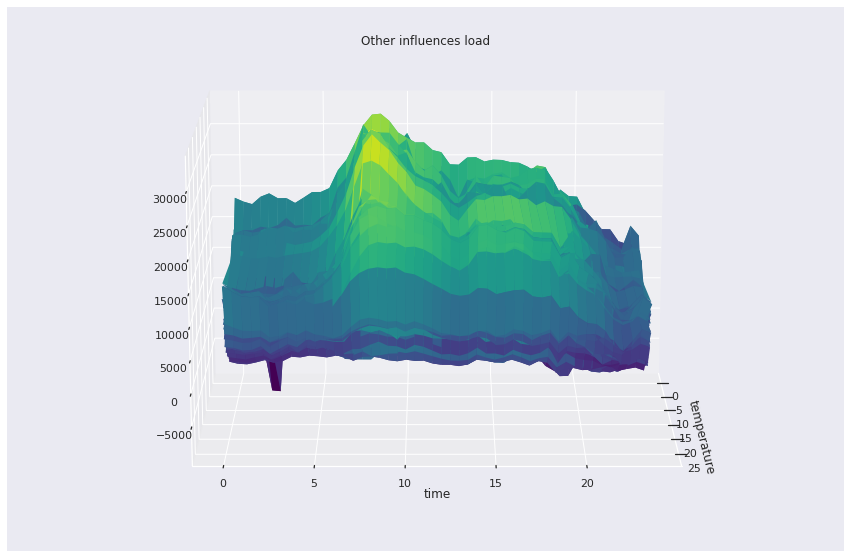

In [591]:
X = np.tile(fixed_part[:,0].reshape(-1,1),(1,48))
Y = np.tile(np.arange(0,24,step=0.5).reshape(1,-1), (X.shape[0],1))
Z = fixed_part[:,1:]
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('temperature')
ax.set_ylabel('time')
ax.set_title('Other influences load');

ax.view_init(15, 0)

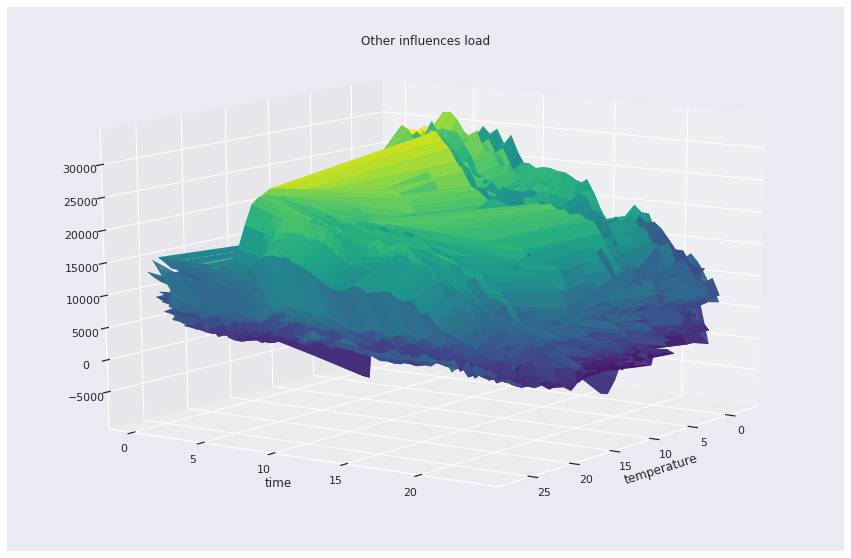

In [592]:
X = np.tile(fixed_part[:,0].reshape(-1,1),(1,48))
Y = np.tile(np.arange(0,24,step=0.5).reshape(1,-1), (X.shape[0],1))
Z = fixed_part[:,1:]
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('temperature')
ax.set_ylabel('time')
ax.set_title('Other influences load');

ax.view_init(15, 35)

## Pour avoir la distribution des charges "thermo-sensibles" moyennes par jour en fonction de la température

In [593]:
#categories = calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])]-np.min(calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])])-1
categories = calendar_info['train']['season'].iloc[idx]
colormap = plt.cm.get_cmap('tab10').colors
plt.figure(figsize=(15,10))
for cat in np.unique(categories):
    id_cat = np.where(categories==cat)[0]
    plt.scatter(thermo_part[id_cat,0],np.mean(thermo_part[id_cat,1:], axis=1), marker='+', color=colormap[cat], label=str(cat))
    plt.legend(loc='best')
    plt.xlabel('temperature (°C)')
    plt.ylabel('mean influenced load (MW)')

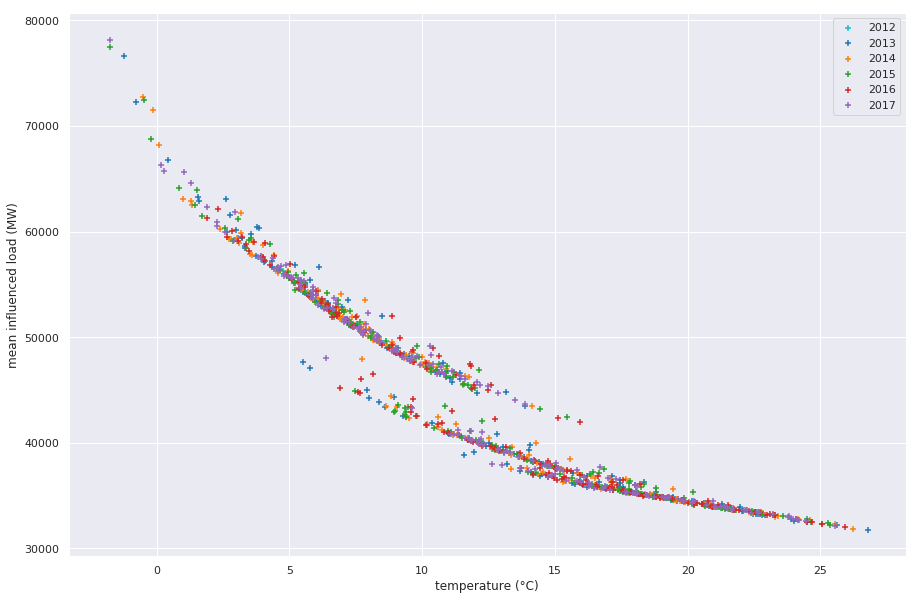

In [594]:
categories = calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])]-np.min(calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])])-1
#categories = calendar_info['train']['season'].iloc[idx]
colormap = plt.cm.get_cmap('tab10').colors
plt.figure(figsize=(15,10))
for cat in np.unique(categories):
    id_cat = np.where(categories==cat)[0]
    plt.scatter(thermo_part[id_cat,0],np.mean(thermo_part[id_cat,1:], axis=1), marker='+', color=colormap[cat], label=str(2013+cat))
    plt.legend(loc='best')
    plt.xlabel('temperature (°C)')
    plt.ylabel('mean influenced load (MW)')

### Et la partie non thermo sensible

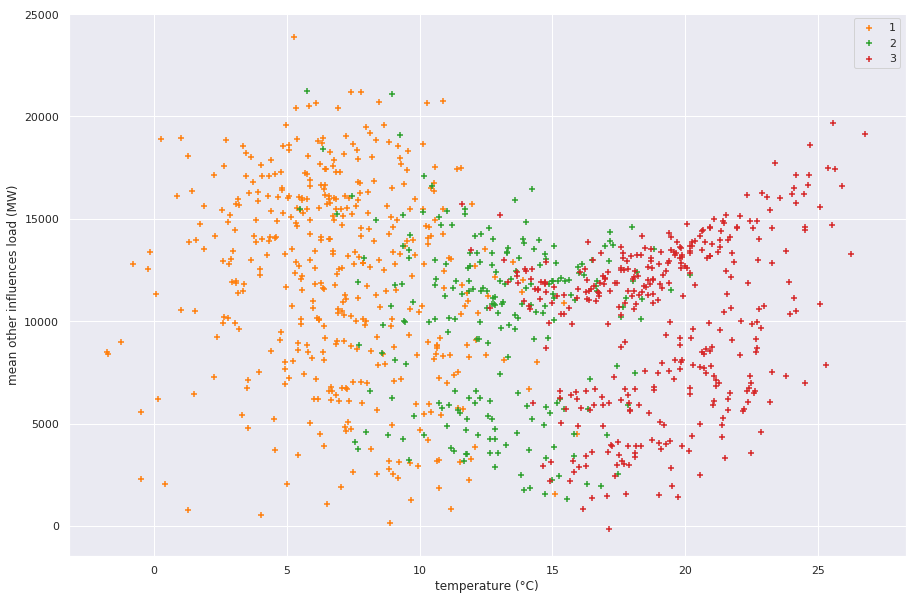

In [595]:
#categories = calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])]-np.min(calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])])-1
categories = calendar_info['train']['season'].iloc[idx]
colormap = plt.cm.get_cmap('tab10').colors
plt.figure(figsize=(15,10))
for cat in np.unique(categories):
    id_cat = np.where(categories==cat)[0]
    plt.scatter(fixed_part[id_cat,0],np.mean(fixed_part[id_cat,1:], axis=1), marker='+', color=colormap[cat], label=str(cat))
    plt.legend(loc='best')
    plt.xlabel('temperature (°C)')
    plt.ylabel('mean other influences load (MW)')

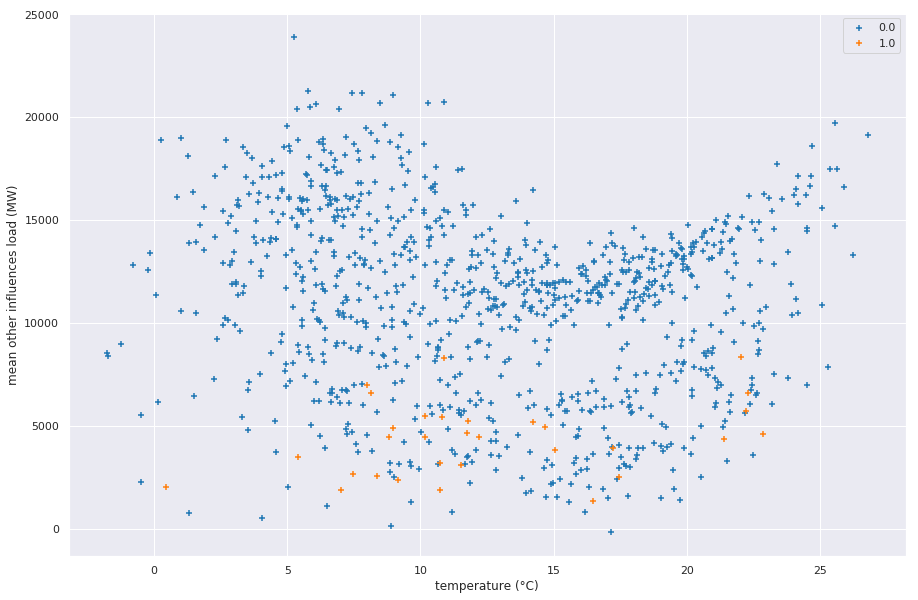

In [602]:
#influence des jours fériés ?
#categories = calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])]-np.min(calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])])-1
categories = calendar_info['train']['season'].iloc[idx]
HolyD = calendar_info['train']['is_holiday_day'].iloc[idx]
colormap = plt.cm.get_cmap('tab10').colors
plt.figure(figsize=(15,10))
for cat in np.unique(HolyD):
    id_cat = np.where(HolyD==cat)[0]
    plt.scatter(fixed_part[id_cat,0],np.mean(fixed_part[id_cat,1:], axis=1), marker='+', color=colormap[int(cat)], label=str(cat))
    plt.legend(loc='best')
    plt.xlabel('temperature (°C)')
    plt.ylabel('mean other influences load (MW)')

### Encoding de la partie non-thermo sensible pour voir s'il reste de l'information résiduelle

In [597]:
test_scaler = StandardScaler()
dataset_residues = {}
dataset_residues['train'] = {}
dataset_residues['train']['x']=[]
dataset_residues['train']['x'].append(test_scaler.fit_transform(fixed_part[:,1:]))
dataset_residues['train']['x'].append(dataset['train']['x'][1][idx,:])

dataset_residues['train']['ds'] = dataset['train']['ds'].iloc[idx].copy()
dataset_residues['train']['y'] = dataset_residues['train']['x'][0]


In [598]:
#Autoencoder
name_model = 'cae_conso-M_T_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/Thermo/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/Thermo/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
model_residues = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1, InfoVAE = True,
                                beta=K.variable(0.4,dtype='float32'), gamma=K.variable(8.,dtype='float32'), is_L2_Loss=False,
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 3), (None, 3 5428        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 3)            0        



--- START TRAINING ---



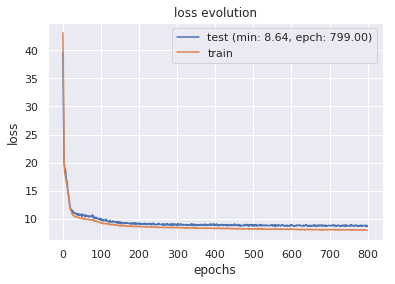

In [599]:
model_residues.main_train(dataset_residues, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[],validation_split=0.1)

In [600]:
x_encoded_res = model_residues.encoder.predict(dataset_residues['train']['x'])[0]

Mutual Information Gap : 0.07
Mutual Information Gap : 0.07


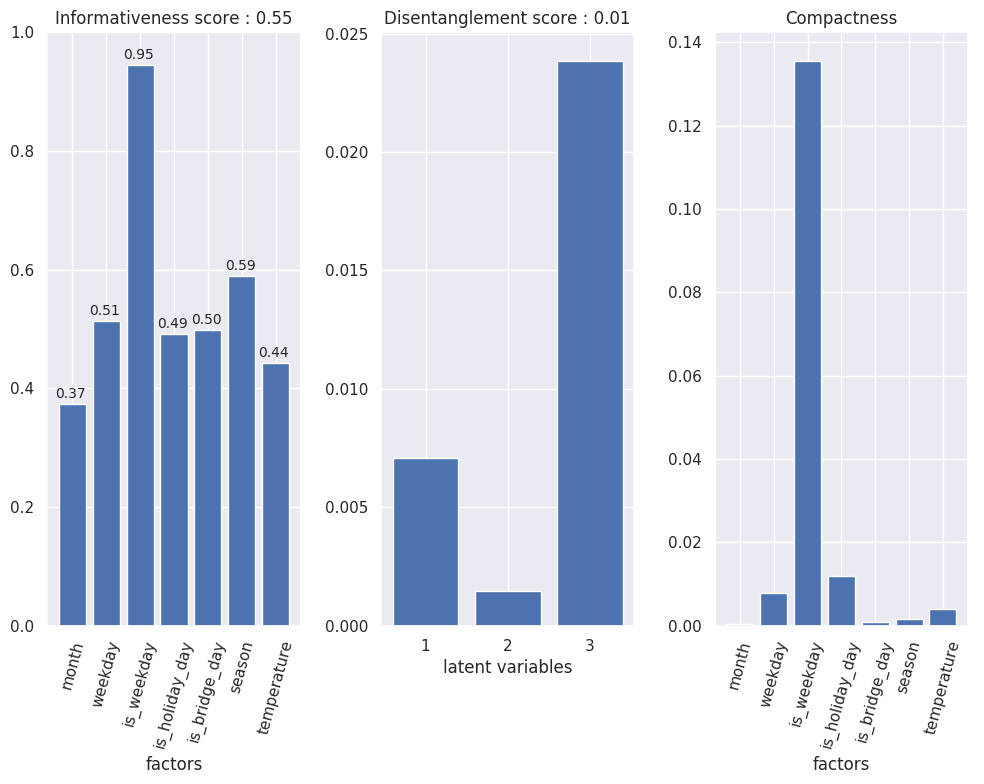

In [601]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded_res, factorMatrix['train'][idx,:], factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])
display_metrics(model_eval, z_dim, factorDesc)

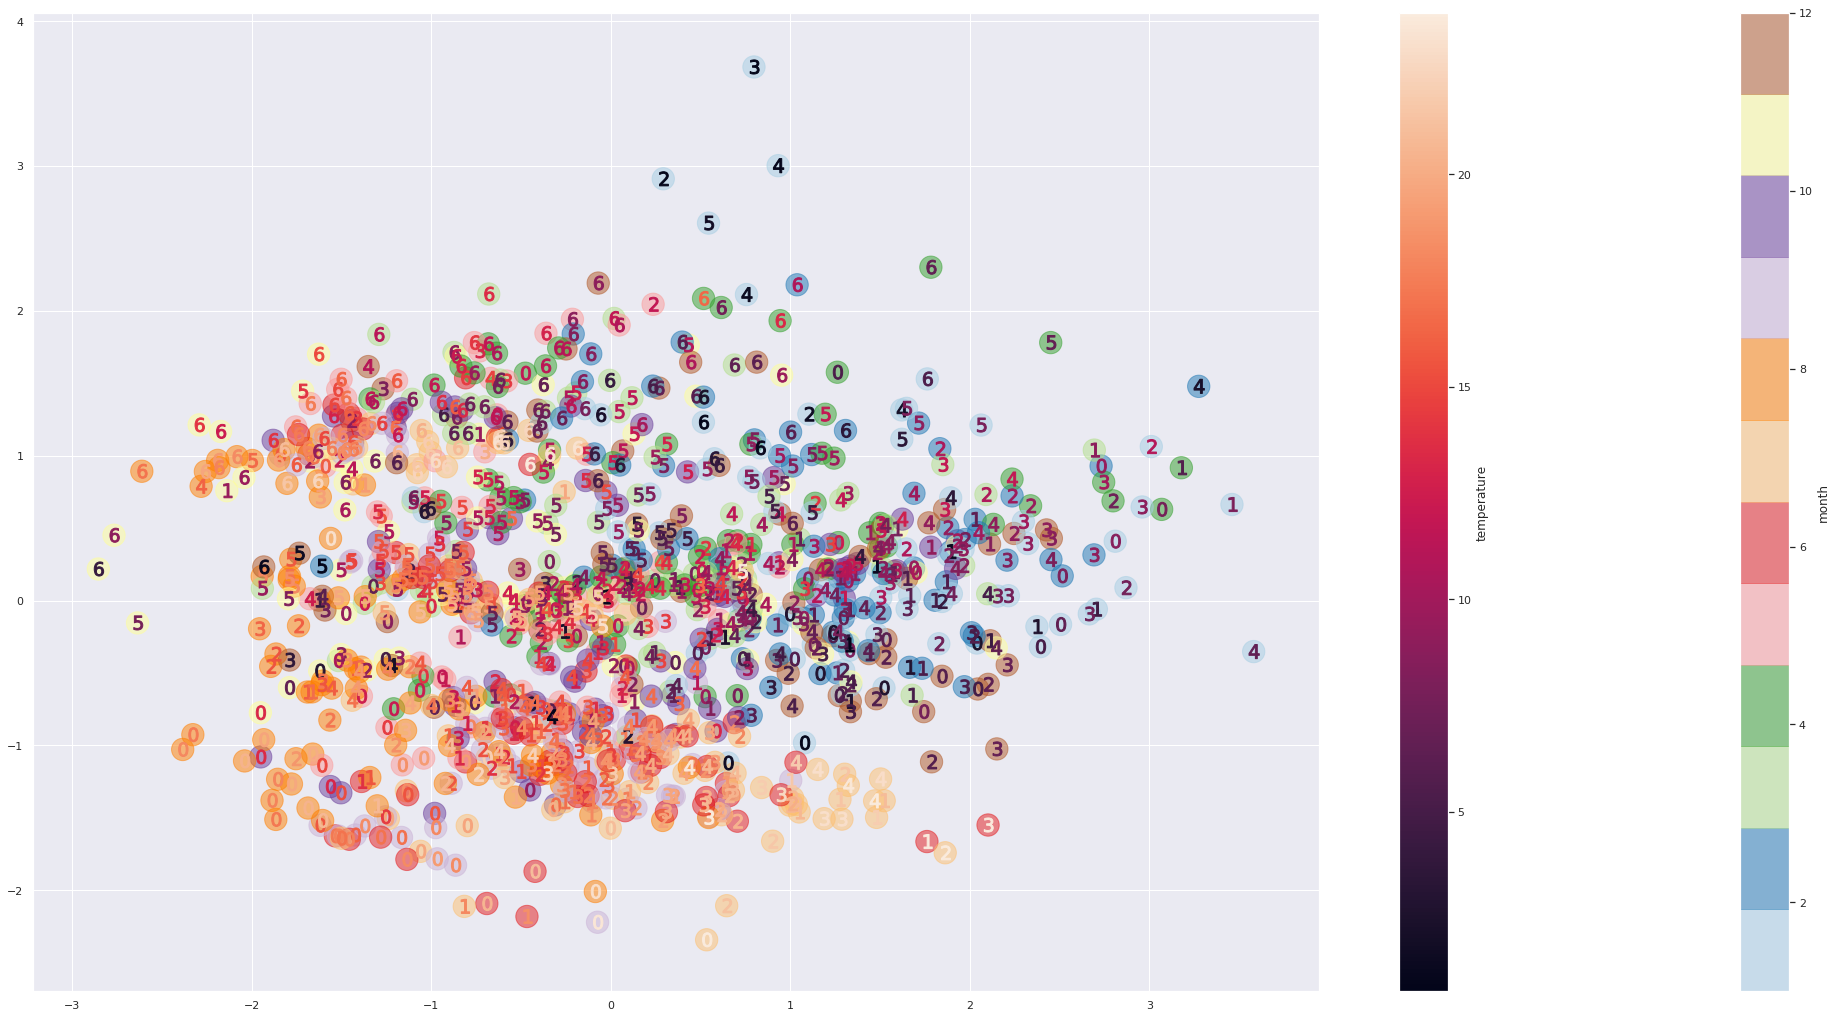

In [206]:
prez_2D(x_encoded_res,factorMatrix['train'][idx,:])

# 2e définition de thermo-sensibilité : par rapport à une température de référence

$\mathbb{E} \left[p_\theta(X|T_0,S_0) - p_\theta(X|T_{ref},S_{ref})\right]$

Pour l'implémentation on choisit une température de référence par saison pour avoir une plus petite erreur d'approximation avec le modèle choisit (qui overfitte un petit peu). La différence entre saisons considérées est ensuite ajoutée.

Donc en pratique c'est plus $\mathbb{E} \left[p_\theta(X|T_0,S_0)\right] - X|T_{ref},S_{ref} + \Delta_{season}$

2013-06-04 00:00:00 3


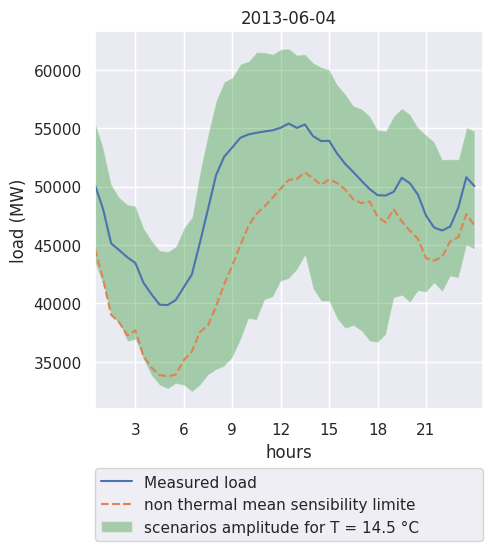

In [440]:
indice=158
q_alpha=0.01

#récupération des conditions
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
k=5000
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling des facteurs non thermo-sensibles
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


#decoding
x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


x = dataset_temp_leap['train']['x'][0][indice,:]

#conditions de référence
cond_ref= np.tile(dataset_temp_leap['train']['x'][2][ind_ref[int(season_ex-1)],:].reshape(1,-1), (k,1))

x_hat_pred_ref = conso_ref[int(season_ex-1)]
delta_conso_ref = conso_ref[int(season_ex-1)] - conso_ref[2]

#différence et rattrapage
thermal_part = np.mean(x_hat_pred - x_hat_pred_ref,axis=0) + delta_conso_ref

scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='scenarios amplitude for T = %0.1f °C'%np.mean(cond_ind[0]));
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);



2013-07-22 00:00:00 3


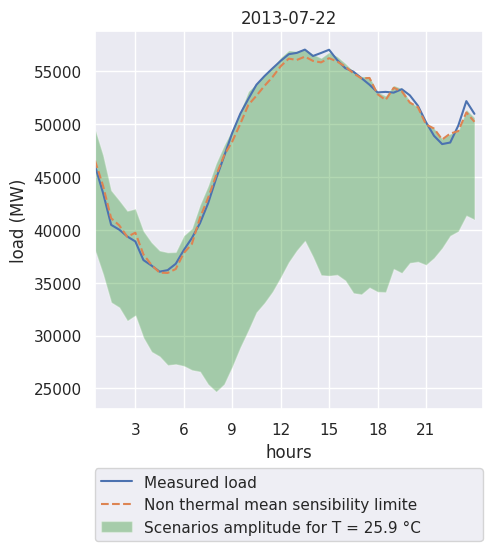

In [496]:
indice=206
q_alpha=0.01

#récupération des conditions
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
k=5000
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling des facteurs non thermo-sensibles
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


#decoding
x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


x = dataset_temp_leap['train']['x'][0][indice,:]

#conditions de référence
cond_ref= np.tile(dataset_temp_leap['train']['x'][2][ind_ref[int(season_ex-1)],:].reshape(1,-1), (k,1))

x_hat_pred_ref = conso_ref[int(season_ex-1)]
delta_conso_ref = conso_ref[int(season_ex-1)] - conso_ref[2]

#différence et rattrapage
thermal_part = np.mean(x_hat_pred - x_hat_pred_ref,axis=0) + delta_conso_ref

scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='scenarios amplitude for T = %0.1f °C'%np.mean(cond_ind[0]));
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);



In [439]:
indice=218

#récupération des conditions
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
k=5000
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling des facteurs non thermo-sensibles
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


#decoding
x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


x = dataset_temp_leap['train']['x'][0][indice,:]

#conditions de référence
cond_ref= np.tile(dataset_temp_leap['train']['x'][2][ind_ref[int(season_ex-1)],:].reshape(1,-1), (k,1))

x_hat_pred_ref = conso_ref[int(season_ex-1)]
delta_conso_ref = conso_ref[int(season_ex-1)] - conso_ref[2]

#différence et rattrapage
thermal_part = np.mean(x_hat_pred - x_hat_pred_ref,axis=0) + delta_conso_ref

scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='scenarios amplitude for T = %0.1f °C'%np.mean(cond_ind[0]));
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);



2013-08-03 00:00:00 3


2013-09-10 00:00:00 3


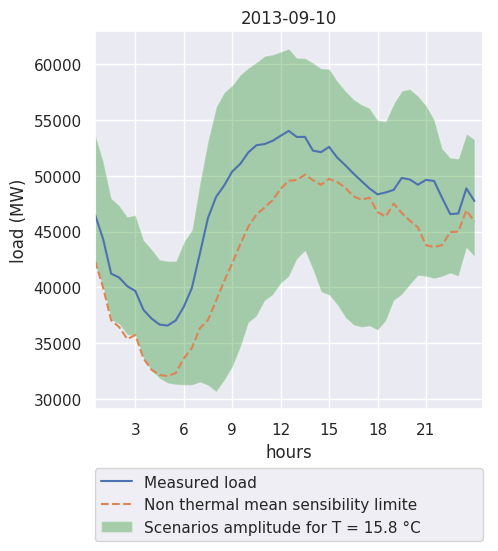

In [497]:
indice=256

#récupération des conditions
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
k=5000
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling des facteurs non thermo-sensibles
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


#decoding
x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


x = dataset_temp_leap['train']['x'][0][indice,:]

#conditions de référence
cond_ref= np.tile(dataset_temp_leap['train']['x'][2][ind_ref[int(season_ex-1)],:].reshape(1,-1), (k,1))

x_hat_pred_ref = conso_ref[int(season_ex-1)]
delta_conso_ref = conso_ref[int(season_ex-1)] - conso_ref[2]

#différence et rattrapage
thermal_part = np.mean(x_hat_pred - x_hat_pred_ref,axis=0) + delta_conso_ref

scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='scenarios amplitude for T = %0.1f °C'%np.mean(cond_ind[0]));
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);



In [498]:
indice=367

#récupération des conditions
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
k=5000
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#sampling des facteurs non thermo-sensibles
z_coord = GM.sample(n_samples=k)[0]

cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]


#decoding
x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


x = dataset_temp_leap['train']['x'][0][indice,:]

#conditions de référence
cond_ref= np.tile(dataset_temp_leap['train']['x'][2][ind_ref[int(season_ex-1)],:].reshape(1,-1), (k,1))

x_hat_pred_ref = conso_ref[int(season_ex-1)]
delta_conso_ref = conso_ref[int(season_ex-1)] - conso_ref[2]

#différence et rattrapage
thermal_part = np.mean(x_hat_pred - x_hat_pred_ref,axis=0) + delta_conso_ref

scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='scenarios amplitude for T = %0.1f °C'%np.mean(cond_ind[0]));
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);



2013-12-30 00:00:00 1


In [396]:
#calculer le gradient de température
num=1000
grad_list=[]
fix_list=[]
idx = np.random.choice(range(nPoints), size=num, replace=False)

for idd in idx:
    k=10000
    season_ex = calendar_info['train']['season'].values[idd]

    cond_ind = dataset_temp_leap['train']['x'][2][idd,:]
    tau_ind = dataset_temp_leap['train']['x'][1][idd,:]
    mean_temp = cond_ind[0]

    z_coord = GM.sample(n_samples=k)[0]
    
    
    cond=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]

    

    x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))


    x = dataset_temp_leap['train']['x'][0][idd,:]


    cond_ref= np.tile(dataset_temp_leap['train']['x'][2][ind_ref[int(season_ex-1)],:].reshape(1,-1), (k,1))

    x_hat_pred_ref = conso_ref[int(season_ex-1)]
    delta_conso_ref = conso_ref[int(season_ex-1)] - conso_ref[2]

    thermal_part = np.mean(x_hat_pred - x_hat_pred_ref,axis=0) + delta_conso_ref

    scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
    scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

    non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part


    grad_list.append(np.c_[mean_temp.reshape(1,-1), thermal_part.reshape(1,-1)])
    fix_list.append(np.c_[mean_temp.reshape(1,-1), (non_thermal).reshape(1,-1)])
    

In [397]:
thermo_part_2 = np.asarray(grad_list).reshape(num,49) 
fixed_part_2 = np.asarray(fix_list).reshape(num,49)

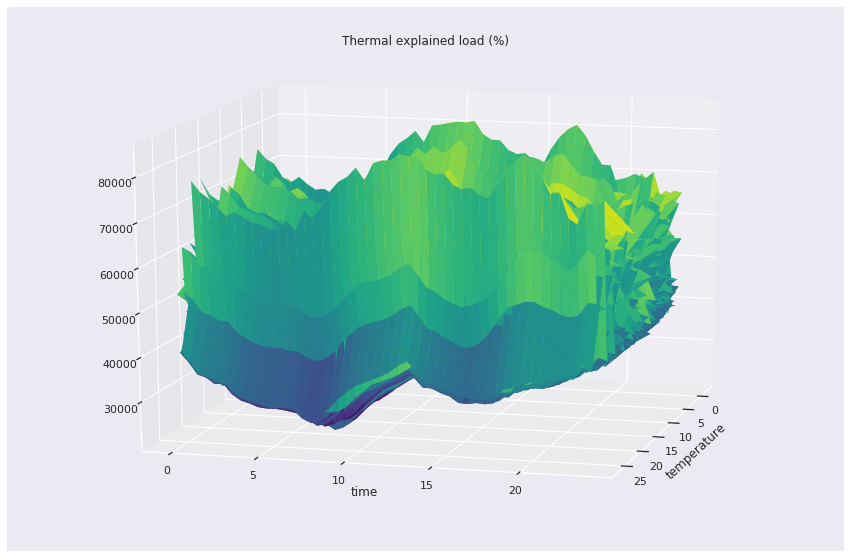

In [398]:
from mpl_toolkits import mplot3d
X = np.tile(thermo_part_2[:,0].reshape(-1,1),(1,48))
Y = np.tile(np.arange(0,24,step=0.5).reshape(1,-1), (X.shape[0],1))
Z = thermo_part[:,1:]
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('temperature')
ax.set_ylabel('time')
ax.set_title('Thermal explained load (%)');

ax.view_init(15, 15)

In [399]:
X = np.tile(fixed_part_2[:,0].reshape(-1,1),(1,48))
Y = np.tile(np.arange(0,24,step=0.5).reshape(1,-1), (X.shape[0],1))
Z = fixed_part[:,1:]
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('temperature')
ax.set_ylabel('time')
ax.set_title('Other influences load');

ax.view_init(15, 0)

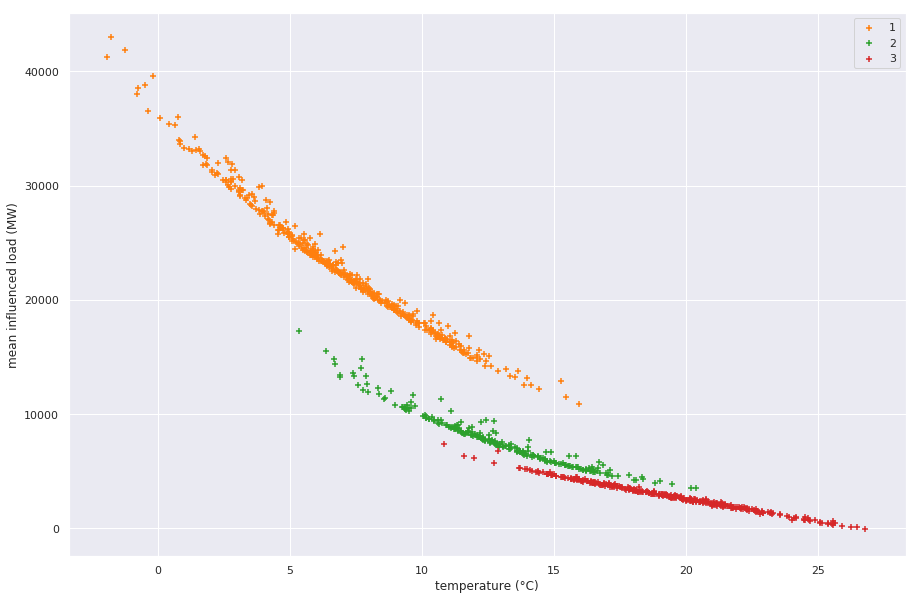

In [400]:
#categories = calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])]-np.min(calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])])-1
categories = calendar_info['train']['season'].iloc[idx]
colormap = plt.cm.get_cmap('tab10').colors
plt.figure(figsize=(15,10))
for cat in np.unique(categories):
    id_cat = np.where(categories==cat)[0]
    plt.scatter(thermo_part_2[id_cat,0],np.mean(thermo_part_2[id_cat,1:], axis=1), marker='+', color=colormap[cat], label=str(cat))
    plt.legend(loc='best')
    plt.xlabel('temperature (°C)')
    plt.ylabel('mean influenced load (MW)')

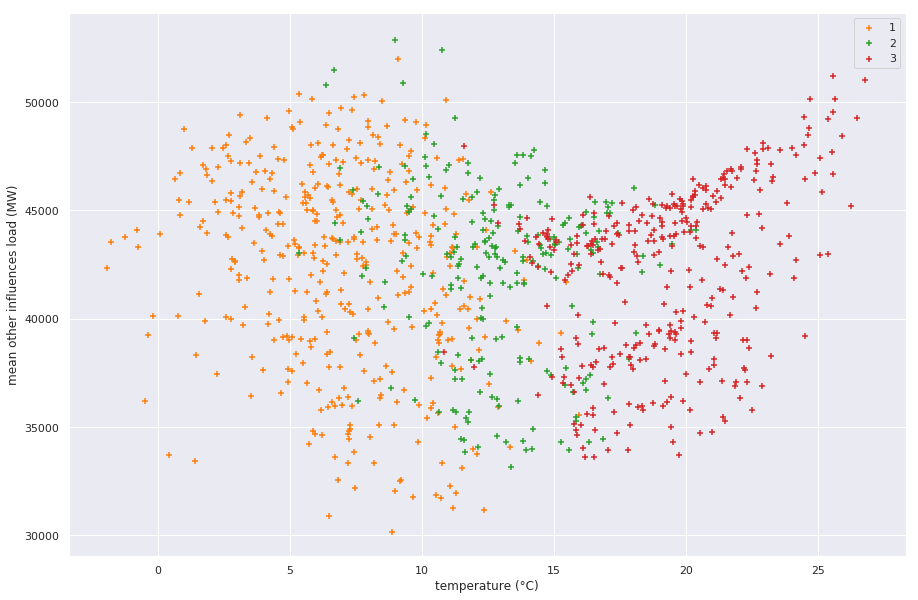

In [401]:
#categories = calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])]-np.min(calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])])-1
categories = calendar_info['train']['season'].iloc[idx]
colormap = plt.cm.get_cmap('tab10').colors
plt.figure(figsize=(15,10))
for cat in np.unique(categories):
    id_cat = np.where(categories==cat)[0]
    plt.scatter(fixed_part_2[id_cat,0],np.mean(fixed_part_2[id_cat,1:], axis=1), marker='+', color=colormap[cat], label=str(cat))
    plt.legend(loc='best')
    plt.xlabel('temperature (°C)')
    plt.ylabel('mean other influences load (MW)')

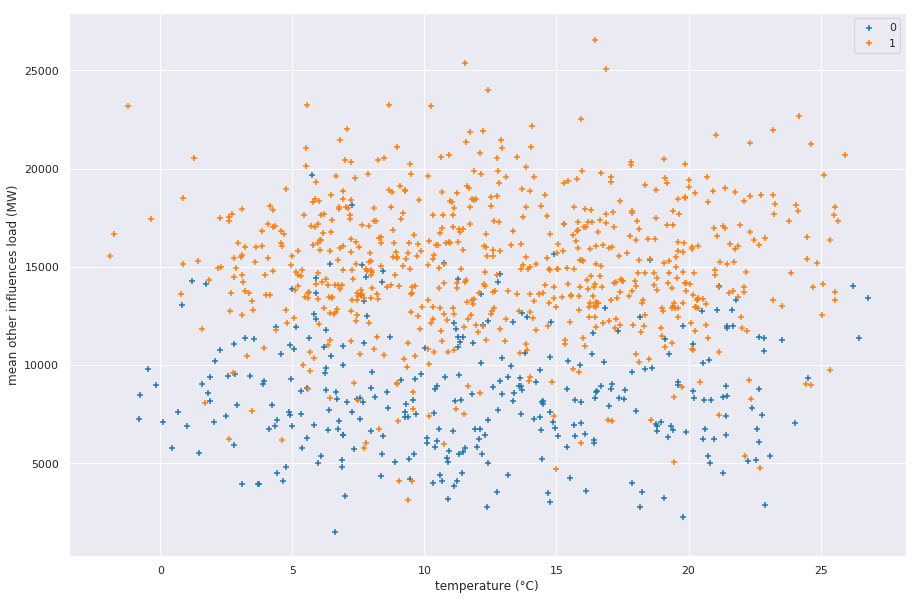

In [523]:
#influence des jours fériés ?
#categories = calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])]-np.min(calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])])-1
categories = calendar_info['train']['season'].iloc[idx]
HolyD = calendar_info['train']['is_weekday'].iloc[idx]
colormap = plt.cm.get_cmap('tab10').colors
plt.figure(figsize=(15,10))
for cat in np.unique(HolyD):
    id_cat = np.where(HolyD==cat)[0]
    plt.scatter(fixed_part_2[id_cat,0],np.mean(fixed_part[id_cat,1:], axis=1), marker='+', color=colormap[int(cat)], label=str(cat))
    plt.legend(loc='best')
    plt.xlabel('temperature (°C)')
    plt.ylabel('mean other influences load (MW)')

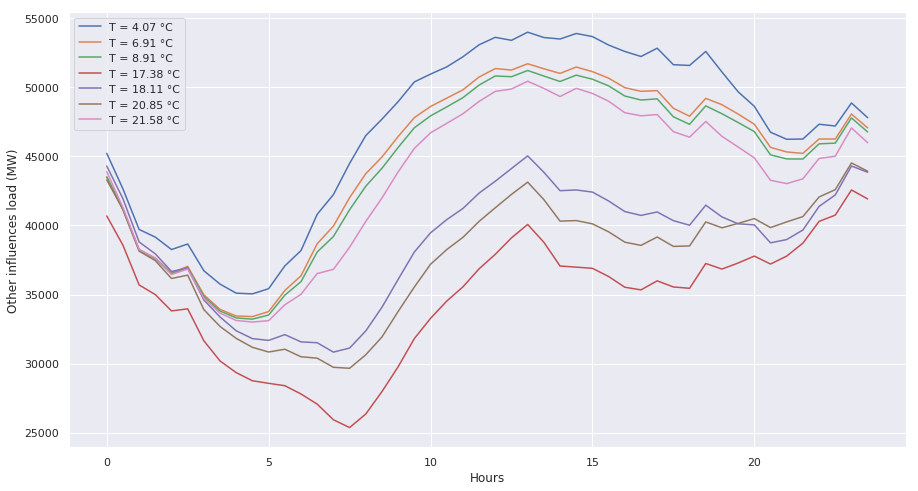

In [412]:
plt.figure(figsize=(15,8))
for ind in (choices[np.argsort(fixed_part_2[(choices+18),0])]+18):
    
    plt.plot(np.arange(48,step=1)/2,fixed_part_2[ind,1:], label='T = %0.2f °C'%fixed_part_2[ind,0])
plt.ylabel('Other influences load (MW)')
plt.xlabel('Hours')
plt.legend(loc='best')

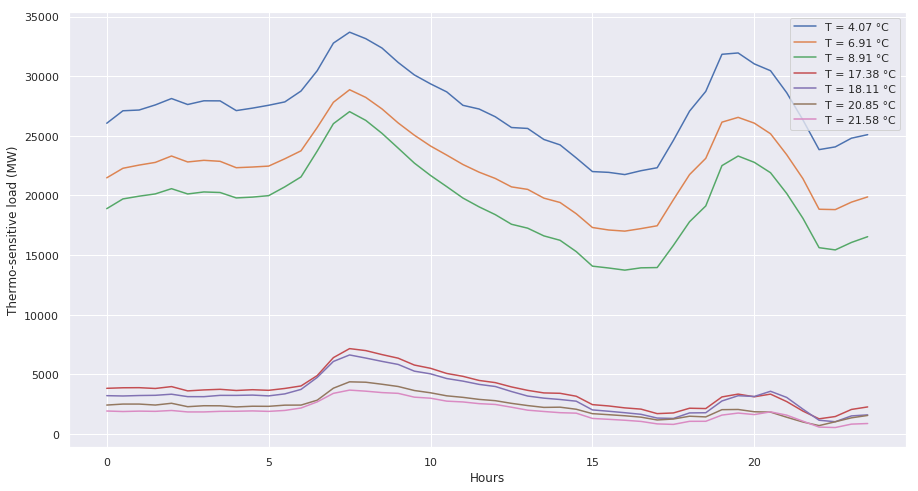

In [413]:
plt.figure(figsize=(15,8))
for ind in (choices[np.argsort(thermo_part_2[(choices+18),0])]+18):
    
    plt.plot(np.arange(48,step=1)/2,thermo_part_2[ind,1:], label='T = %0.2f °C'%thermo_part_2[ind,0])
plt.ylabel('Thermo-sensitive load (MW)')
plt.xlabel('Hours')
plt.legend(loc='best')

In [414]:
test_scaler = StandardScaler()
dataset_residues = {}
dataset_residues['train'] = {}
dataset_residues['train']['x']=[]
dataset_residues['train']['x'].append(test_scaler.fit_transform(fixed_part_2[:,1:]))
dataset_residues['train']['x'].append(dataset['train']['x'][1][idx,:])

dataset_residues['train']['ds'] = dataset['train']['ds'].iloc[idx].copy()
dataset_residues['train']['y'] = dataset_residues['train']['x'][0]


In [415]:
#Autoencoder
name_model = 'cae_conso-M_T_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/Thermo/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/Thermo/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
model_residues = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1, InfoVAE = True,
                                beta=K.variable(0.4,dtype='float32'), gamma=K.variable(8.,dtype='float32'), is_L2_Loss=False,
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 3), (None, 3 5428        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 3)            0        



--- START TRAINING ---



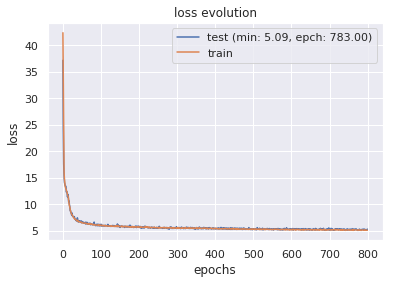

In [416]:
model_residues.main_train(dataset_residues, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[],validation_split=0.1)

In [417]:
x_encoded_res = model_residues.encoder.predict(dataset_residues['train']['x'])[0]

In [418]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded_res, factorMatrix['train'][idx,:], factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])
display_metrics(model_eval, z_dim, factorDesc)

Mutual Information Gap : 0.12
Mutual Information Gap : 0.12


In [419]:
prez_2D(x_encoded_res,factorMatrix['train'][idx,:])

# 3e définition de sensibilité: sensibilité locale ou gradient

On calcule  $\mathbb{E} \frac {p_\theta(X|T_0',S_0) - p_\theta(X|T_0,S_0)}{T_0' - T_0}$   où $T_0' = T_0 \pm 1\$°C

In [279]:
indice=158
q_alpha=0.01

#Récupération des conditions
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
k=5000
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#Sampling des autres facteurs
z_coord = GM.sample(n_samples=k)[0]


cond_ref=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]



x_hat_pred_ref = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond_ref]))


x = dataset_temp_leap['train']['x'][0][indice,:]

#choix aléatoire de la direction de la sensibilité, que l'on rajoute aux conditions de decodage
delta_T = np.random.uniform(low=-1.0, high=1.0, size=k).reshape(-1,1)


cond= np.tile(cond_ind.reshape(1,-1), (k,1))+np.c_[delta_T, delta_T, delta_T, np.zeros((k,3))]

#decodage du profil de température augmentée (ou diminuée)
x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))

#calculs de gradient
thermal_grad = np.mean((x_hat_pred - x_hat_pred_ref)/delta_T,axis=0) 
thermal_part = thermal_grad * (cond_ind[0] - temp_ref[2]) #intégration constante depuis la température de réf (approximation pour avoir une courbe)

#calcul amplitude des scénarios
scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='scenarios amplitude for T = %0.1f °C'%np.mean(cond_ind[:48]));
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);


2013-06-04 00:00:00 3


2013-08-03 00:00:00 3


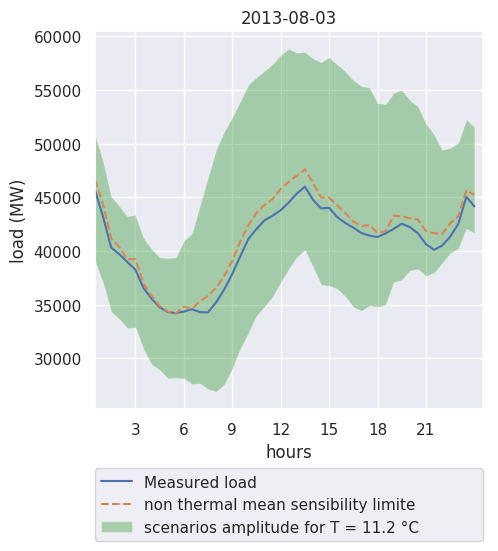

In [278]:
indice=218
q_alpha=0.01

#Récupération des conditions
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
k=5000
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#Sampling des autres facteurs
z_coord = GM.sample(n_samples=k)[0]


cond_ref=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]



x_hat_pred_ref = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond_ref]))


x = dataset_temp_leap['train']['x'][0][indice,:]

#choix aléatoire de la direction de la sensibilité, que l'on rajoute aux conditions de decodage
delta_T = np.random.uniform(low=-1.0, high=1.0, size=k).reshape(-1,1)


cond= np.tile(cond_ind.reshape(1,-1), (k,1))+np.c_[delta_T, delta_T, delta_T, np.zeros((k,3))]

#decodage du profil de température augmentée (ou diminuée)
x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))

#calculs de gradient
thermal_grad = np.mean((x_hat_pred - x_hat_pred_ref)/delta_T,axis=0) 
thermal_part = thermal_grad * (cond_ind[0] - temp_ref[2]) #intégration constante depuis la température de réf (approximation pour avoir une courbe)

#calcul amplitude des scénarios
scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='scenarios amplitude for T = %0.1f °C'%np.mean(cond_ind[:48]));
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);


2013-09-10 00:00:00 3


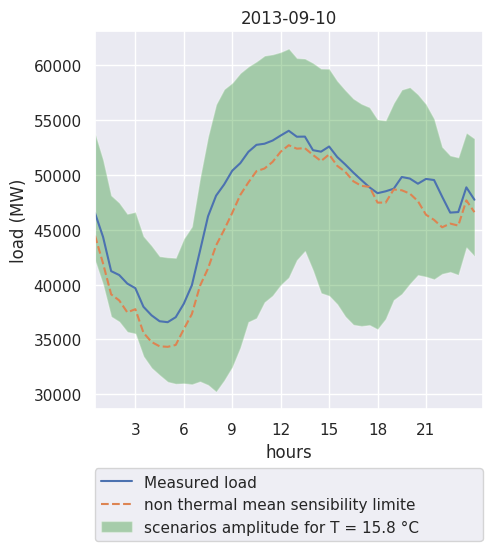

In [436]:
indice=256
q_alpha=0.01

#Récupération des conditions
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
k=5000
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#Sampling des autres facteurs
z_coord = GM.sample(n_samples=k)[0]


cond_ref=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]



x_hat_pred_ref = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond_ref]))


x = dataset_temp_leap['train']['x'][0][indice,:]

#choix aléatoire de la direction de la sensibilité, que l'on rajoute aux conditions de decodage
delta_T = np.random.uniform(low=-1.0, high=1.0, size=k).reshape(-1,1)


cond= np.tile(cond_ind.reshape(1,-1), (k,1))+np.c_[delta_T, delta_T, delta_T, np.zeros((k,3))]

#decodage du profil de température augmentée (ou diminuée)
x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))

#calculs de gradient
thermal_grad = np.mean((x_hat_pred - x_hat_pred_ref)/delta_T,axis=0) 
thermal_part = thermal_grad * (cond_ind[0] - temp_ref[2]) #intégration constante depuis la température de réf (approximation pour avoir une courbe)

#calcul amplitude des scénarios
scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='scenarios amplitude for T = %0.1f °C'%np.mean(cond_ind[:48]));
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);


2013-12-30 00:00:00 1


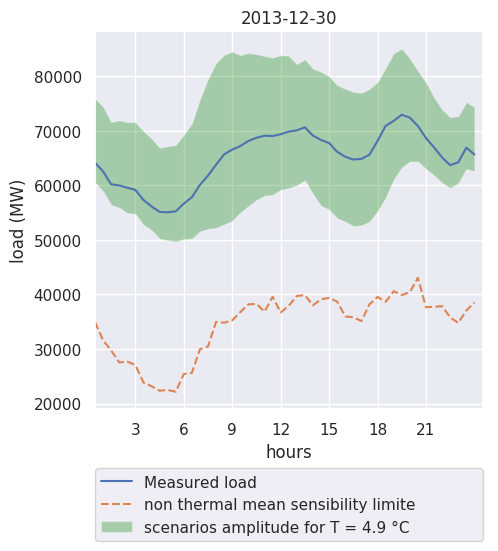

In [435]:
indice=367
q_alpha=0.01

#Récupération des conditions
season_ex = calendar_info['train']['season'].values[indice]
print(calendar_info['train'].ds.iloc[indice],season_ex)
k=5000
cond_ind = dataset_temp_leap['train']['x'][2][indice,:]
tau_ind = dataset_temp_leap['train']['x'][1][indice,:]

#Sampling des autres facteurs
z_coord = GM.sample(n_samples=k)[0]


cond_ref=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]



x_hat_pred_ref = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond_ref]))


x = dataset_temp_leap['train']['x'][0][indice,:]

#choix aléatoire de la direction de la sensibilité, que l'on rajoute aux conditions de decodage
delta_T = np.random.uniform(low=-1.0, high=1.0, size=k).reshape(-1,1)


cond= np.tile(cond_ind.reshape(1,-1), (k,1))+np.c_[delta_T, delta_T, delta_T, np.zeros((k,3))]

#decodage du profil de température augmentée (ou diminuée)
x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))

#calculs de gradient
thermal_grad = np.mean((x_hat_pred - x_hat_pred_ref)/delta_T,axis=0) 
thermal_part = thermal_grad * (cond_ind[0] - temp_ref[2]) #intégration constante depuis la température de réf (approximation pour avoir une courbe)

#calcul amplitude des scénarios
scenario_inf = np.quantile(x_hat_pred,q_alpha,axis=0)
scenario_sup = np.quantile(x_hat_pred,1-q_alpha,axis=0)

non_thermal = np.mean(scaler.inverse_transform(model_CVAE_cond_leap.cvae.predict([np.tile(x.reshape(1,-1),(k,1)),np.tile(tau_ind.reshape(1,-1),(k,1)),cond])[0]),axis=0) - thermal_part
display_loads(list_x=[x],scaler=scaler,labels=['Measured load'], date = calendar_info['train'].ds.dt.date[indice].isoformat())

plt.grid()
plt.plot(non_thermal, '--', label = 'non thermal mean sensibility limite')
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='scenarios amplitude for T = %0.1f °C'%np.mean(cond_ind[:48]));
plt.legend(bbox_to_anchor=(0.0, -0.35, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);


In [570]:
#calculer le gradient de température
num=1000
grad_list=[]
idx = np.random.choice(range(nPoints), size=num, replace=False)

for idd in idx:
    k=5000
    season_ex = calendar_info['train']['season'].values[idd]

    cond_ind = dataset_temp_leap['train']['x'][2][idd,:]
    tau_ind = dataset_temp_leap['train']['x'][1][idd,:]
    mean_temp = cond_ind[0]

    z_coord = GM.sample(n_samples=k)[0]

    cond_ref=np.c_[np.tile(cond_ind.reshape(1,-1),(k,1))]

    x_hat_pred_ref = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond_ref]))

    x = dataset_temp_leap['train']['x'][0][indice,:]

    delta_T = (np.random.randint(2, size=k) *2 -1).reshape(-1,1)


    cond= np.tile(cond_ind.reshape(1,-1), (k,1))+np.c_[delta_T, delta_T, delta_T, np.zeros((k,3))]

    x_hat_pred = scaler.inverse_transform(model_CVAE_cond_leap.decoder.predict([z_coord, cond]))

    thermal_grad = np.mean((x_hat_pred - x_hat_pred_ref)/np.tile(delta_T.reshape(-1,1),(1,48)),axis=0) 
    grad_list.append(np.c_[mean_temp.reshape(1,-1), thermal_grad.reshape(1,-1)])
    

In [571]:
gradient = np.asarray(grad_list)
gradient=gradient[:,0,:]
gradient.shape


(1000, 49)

In [572]:
#sortie du gradient triée selon la température moyenne du profil
sort_temp = np.argsort(gradient[:,0])

gradient = gradient[sort_temp,:]
gradient.shape

(1000, 49)

In [454]:
#gradient moyen sur tous les profils
plt.figure(figsize=(15,8))
plt.plot(np.arange(48)/2,-1*np.mean(gradient[:,1:],axis=0))
plt.ylabel('Average thermo-sensitive gradient (-MW/°C)')
plt.xlabel('Hours')


Text(0.5, 0, 'Hours')

In [507]:
#un gradient d'hiver

plt.figure(figsize=(15,8))
plt.plot(np.arange(48)/2,-1*np.mean(gradient[:50,1:],axis=0))
plt.ylabel('Average thermo-sensitive gradient (-MW/°C) for T ~ %0.2f°C'%np.mean(gradient[:50,0])) 
plt.xlabel('Hours')


Text(0.5, 0, 'Hours')

### Tentative d'intégration à partir de la température de référence

In [573]:
round_temp=np.round(gradient[:,0])
mean_grad=[]
for t in np.unique(round_temp):
    id_t = np.where(round_temp == t)[0]
    mean_grad.append(np.mean(gradient[id_t,1:],axis=0))
mean_grad =np.asarray(mean_grad)


In [574]:
start_int = np.argmin(np.abs(np.unique(round_temp)-temp_ref[2]))
np.unique(round_temp)[start_int]

20.0

In [575]:
start_int

22

In [576]:
start_down = 22
start_up = 23
u_round_temp = np.unique(round_temp)
thermo_part_3 = np.r_[mean_grad[:start_down,:] * np.tile((u_round_temp[:start_down]- u_round_temp[1:(start_down+1)]).reshape(-1,1),(1,48)),
                      mean_grad[start_down,:].reshape(1,-1) * np.tile((u_round_temp[start_down]- temp_ref[2]).reshape(-1,1),(1,48)),
                      mean_grad[start_up,:].reshape(1,-1) * np.tile((u_round_temp[start_up]- temp_ref[2]).reshape(-1,1),(1,48)),
                      mean_grad[(start_up+1):,:] * np.tile((u_round_temp[(start_up+1):len(u_round_temp)]- u_round_temp[(start_up):(len(u_round_temp)-1)]).reshape(-1,1),(1,48))
                     ]

In [577]:
(gradient[start_up,1:]*(temp[start_up,:]-temp_ref[2])).shape

(48,)

In [578]:
start_down = 833
start_up = 834
temp = (dataset_temp['train']['x'][1][idx,:48])[sort_temp,:]
def int_thermo_part(T_ref, gradient):
    start_up = np.argmin(np.abs(np.unique(round_temp)-T_ref))
    start_down = start_up - 1

    thermo_part_3 = np.r_[gradient[:start_down,1:]*(temp[:start_down,:]-temp[1:(start_down +1),:]),
                         (gradient[start_down,1:]*(temp[start_down,:]-T_ref)).reshape(1,-1),
                         (gradient[start_up,1:]*(temp[start_up,:]-T_ref)).reshape(1,-1),
                         gradient[(start_up+1):,1:]*(temp[(start_up+1):,:]-temp[(start_up):999,:])]
    
    int_thermo = np.r_[np.cumsum((thermo_part_3[:start_up,:])[::-1,:],axis=0)[::-1,:],
                        np.cumsum(thermo_part_3[start_up:,:],axis=0)]
    return int_thermo

In [579]:
thermo_part_int_20 = int_thermo_part(temp_ref[2], gradient)
thermo_part_int_0 = int_thermo_part(0, gradient)

thermo_part_int_10 = int_thermo_part(10, gradient)

Text(0, 0.5, 'mean influenced load (MW)')

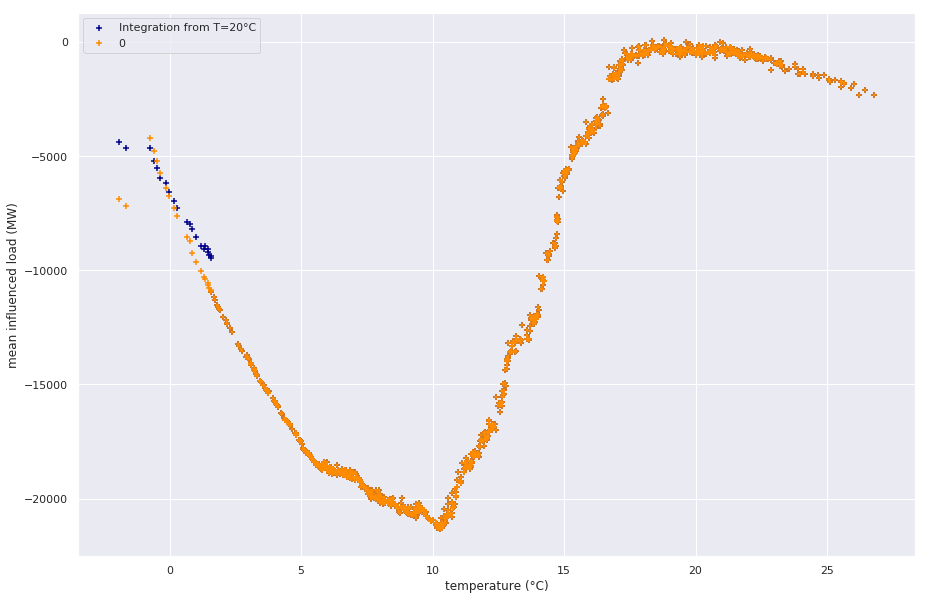

In [584]:
#categories = calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])]-np.min(calendar_info['train']['ds'].dt.year.iloc[idx].values[np.argsort(fixed_part[:,0])])-1
categories = calendar_info['train']['season'].iloc[idx][sort_temp]
colormap = plt.cm.get_cmap('tab10').colors
plt.figure(figsize=(15,10))
#for cat in np.unique(categories):
    #id_cat = np.where(categories==cat)[0]
plt.scatter(gradient[:,0],(np.sum(thermo_part_int_20, axis=1)-np.sum(thermo_part_int_20, axis=1)[834])/48,
            marker='+', color='darkblue', label='Integration from T=20°C')
plt.scatter(gradient[:,0],(np.sum(thermo_part_int_0, axis=1)-np.sum(thermo_part_int_0, axis=1)[834])/48,
            marker='+', color='darkorange', label='0')
#plt.scatter(gradient[:,0],(np.sum(thermo_part_int_10, axis=1)-np.sum(thermo_part_int_10, axis=1)[834])/48,
            #marker='+', color='darkgreen', label='10')

plt.legend(loc='best')
plt.xlabel('temperature (°C)')
plt.ylabel('mean influenced load (MW)')
